In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [ ]:
# Fetch historical data for S&P 500
ticker = "^GSPC"
df = yf.download(ticker, start="2000-01-01", end="2025-01-01")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Calculate daily returns
df["Return"] = df["Close"].pct_change()

In [ ]:
# Moving Averages (SMA, EMA)
df["SMA_10"] = df["Close"].rolling(window=10).mean()
df["SMA_50"] = df["Close"].rolling(window=50).mean()
df["EMA_10"] = df["Close"].ewm(span=10, adjust=False).mean()

In [ ]:
# MACD (12-day EMA - 26-day EMA)
df["EMA_12"] = df["Close"].ewm(span=12, adjust=False).mean()
df["EMA_26"] = df["Close"].ewm(span=26, adjust=False).mean()
df["MACD"] = df["EMA_12"] - df["EMA_26"]
df["MACD_Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()
df["MACD_Hist"] = df["MACD"] - df["MACD_Signal"]

In [ ]:
# Bollinger Bands
df["Rolling_Mean"] = df["Close"].rolling(window=20).mean()
df["Rolling_Std"] = df["Close"].rolling(window=20).std()
df["Upper_BB"] = df["Rolling_Mean"] + (df["Rolling_Std"] * 2)
df["Lower_BB"] = df["Rolling_Mean"] - (df["Rolling_Std"] * 2)

In [ ]:
# Average True Range (ATR)
df["High-Low"] = df["High"] - df["Low"]
df["High-Close"] = np.abs(df["High"] - df["Close"].shift(1))
df["Low-Close"] = np.abs(df["Low"] - df["Close"].shift(1))
df["TR"] = df[["High-Low", "High-Close", "Low-Close"]].max(axis=1)
df["ATR"] = df["TR"].rolling(window=14).mean()

In [ ]:
# On-Balance Volume (OBV)
df["Daily_OBV"] = np.where(df["Close"] > df["Close"].shift(1), df["Volume"],
                           np.where(df["Close"] < df["Close"].shift(1), -df["Volume"], 0))
df["OBV"] = df["Daily_OBV"].cumsum()

In [ ]:
# Volume Price Trend (VPT)
df["VPT"] = (df["Volume"] * (df["Close"].pct_change())).cumsum()

In [ ]:
# High-Low Percentage
df["HL_Perc"] = (df["High"] - df["Low"]) / df["Low"]

In [ ]:
# Sharpe Ratio (Risk-adjusted return)
df["Rolling_Return"] = df["Return"].rolling(window=20).mean()
df["Rolling_Std"] = df["Return"].rolling(window=20).std()
df["Sharpe_Ratio"] = df["Rolling_Return"] / df["Rolling_Std"]

In [ ]:
# Time-based Features
df["Day_of_Week"] = df.index.dayofweek  # 0 = Monday, 4 = Friday
df["Month"] = df.index.month
df["Quarter"] = df.index.quarter
df["Year"] = df.index.year

In [ ]:
# Lagged Features
df["Prev_Close"] = df["Close"].shift(1)
df["Prev_Volume"] = df["Volume"].shift(1)

In [ ]:
df["Target"] = np.where(df["Return"].shift(-1) > 0, 1, 0)  # 1 = Bullish, 0 = Bearish


In [ ]:
df1 = df.dropna()

In [ ]:
df1.isna().sum()

,,0
Price,Ticker,
Close,^GSPC,0
High,^GSPC,0
Low,^GSPC,0
Open,^GSPC,0
Volume,^GSPC,0
Return,,0
SMA_10,,0
SMA_50,,0
EMA_10,,0


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6240 entries, 2000-03-14 to 2024-12-31
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Close, ^GSPC)      6240 non-null   float64
 1   (High, ^GSPC)       6240 non-null   float64
 2   (Low, ^GSPC)        6240 non-null   float64
 3   (Open, ^GSPC)       6240 non-null   float64
 4   (Volume, ^GSPC)     6240 non-null   int64  
 5   (Return, )          6240 non-null   float64
 6   (SMA_10, )          6240 non-null   float64
 7   (SMA_50, )          6240 non-null   float64
 8   (EMA_10, )          6240 non-null   float64
 9   (EMA_12, )          6240 non-null   float64
 10  (EMA_26, )          6240 non-null   float64
 11  (MACD, )            6240 non-null   float64
 12  (MACD_Signal, )     6240 non-null   float64
 13  (MACD_Hist, )       6240 non-null   float64
 14  (Rolling_Mean, )    6240 non-null   float64
 15  (Rolling_Std, )     6240 non-null   f

In [ ]:
df

Price,Close,High,Low,Open,Volume,Return,SMA_10,SMA_50,EMA_10,EMA_12,...,HL_Perc,Rolling_Return,Sharpe_Ratio,Day_of_Week,Month,Quarter,Year,Prev_Close,Prev_Volume,Target
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,1455.219971,1478.000000,1438.359985,1469.250000,931800000,NaN,NaN,NaN,1455.219971,1455.219971,...,0.027559,NaN,NaN,0,1,1,2000,NaN,NaN,0
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000,-0.038345,NaN,NaN,1445.074529,1446.635367,...,0.041354,NaN,NaN,1,1,1,2000,1455.219971,9.318000e+08,1
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000,0.001922,NaN,NaN,1437.262794,1439.785308,...,0.025833,NaN,NaN,2,1,1,2000,1399.420044,1.009000e+09,1
2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000,0.000956,NaN,NaN,1431.115005,1434.195253,...,0.014223,NaN,NaN,3,1,1,2000,1402.109985,1.085500e+09,1
2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000,0.027090,NaN,NaN,1432.997726,1435.314440,...,0.029085,NaN,NaN,4,1,1,2000,1403.449951,1.092300e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,6040.040039,6040.100098,5981.439941,5984.629883,1757720000,0.011043,5999.541992,5933.808203,5990.746969,5993.597635,...,0.009807,0.000475,0.054140,1,12,4,2024,5974.069824,3.593280e+09,0
2024-12-26,6037.589844,6049.750000,6007.370117,6024.970215,2904530000,-0.000406,5994.881982,5938.254805,5999.263855,6000.365667,...,0.007055,0.000169,0.019407,3,12,4,2024,6040.040039,1.757720e+09,0


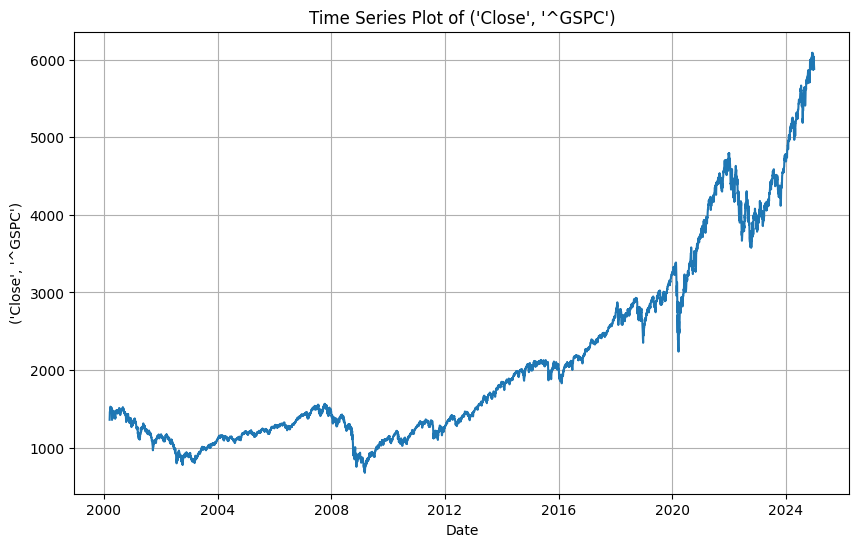

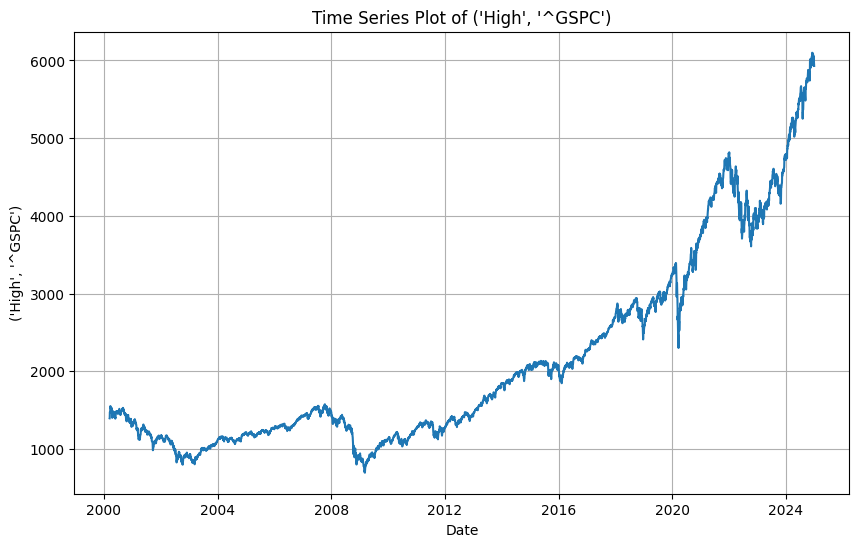

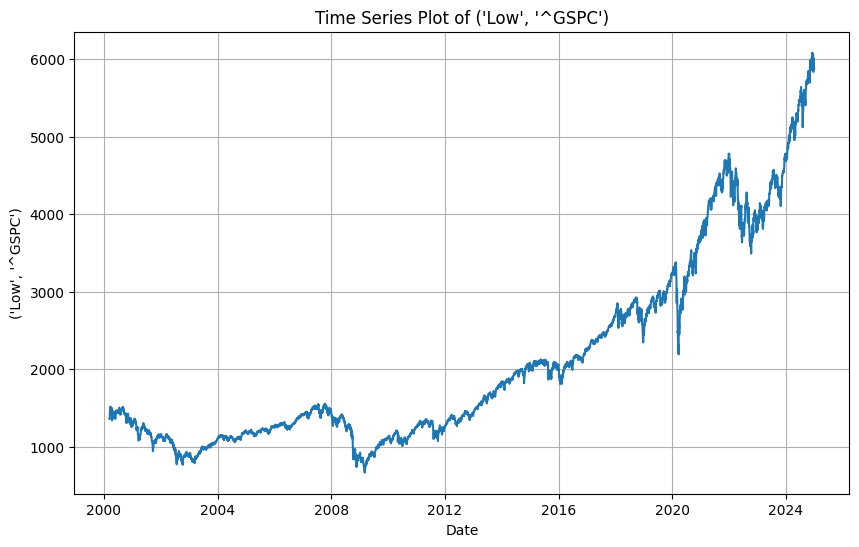

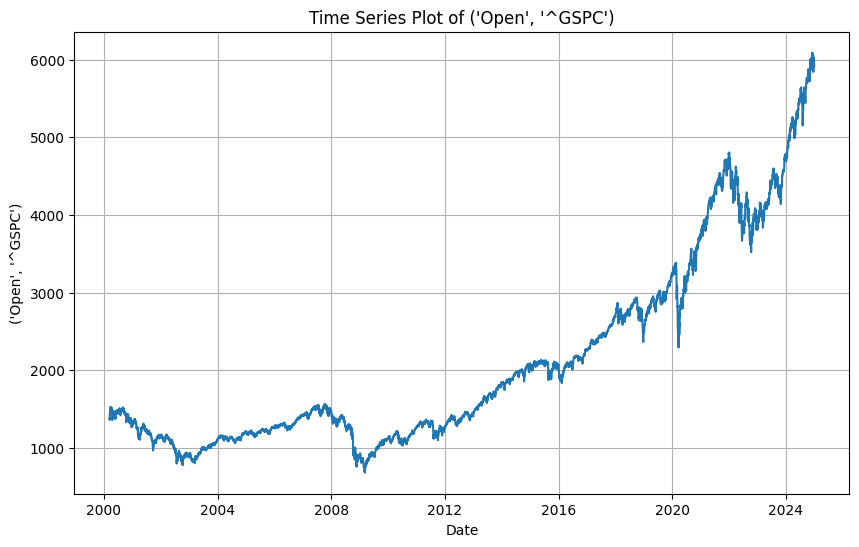

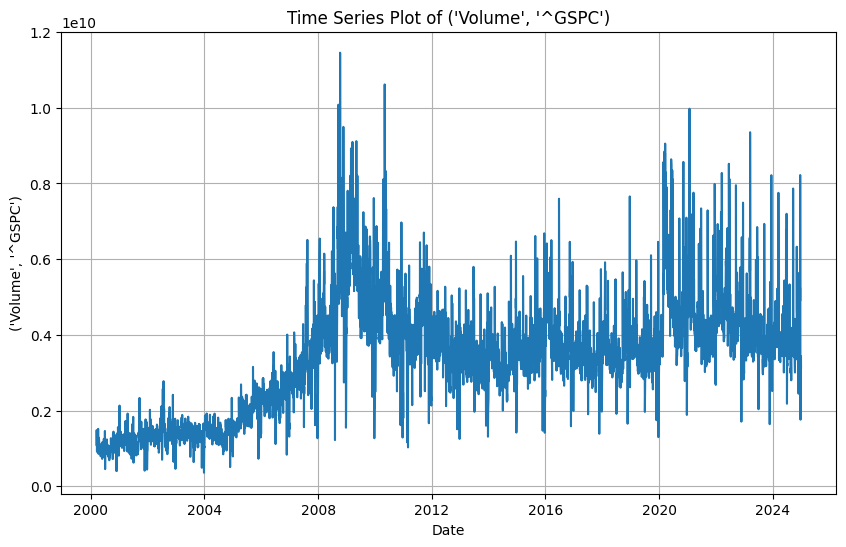

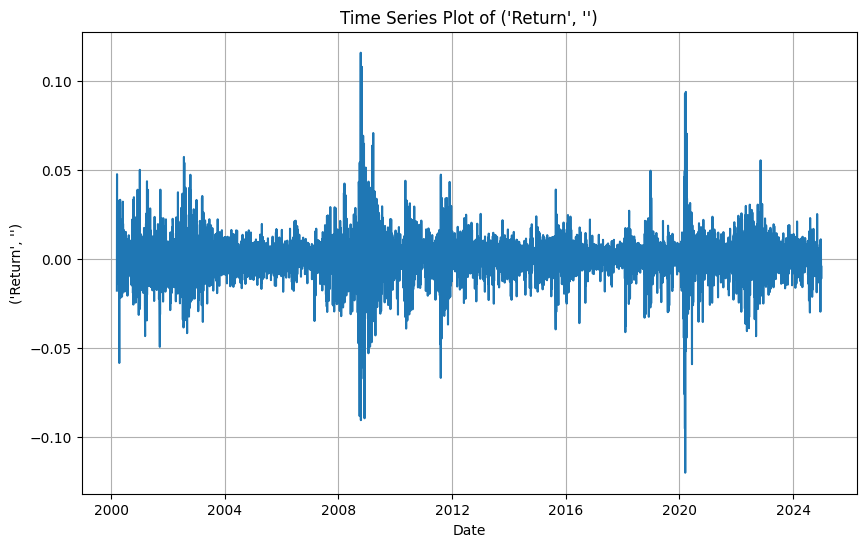

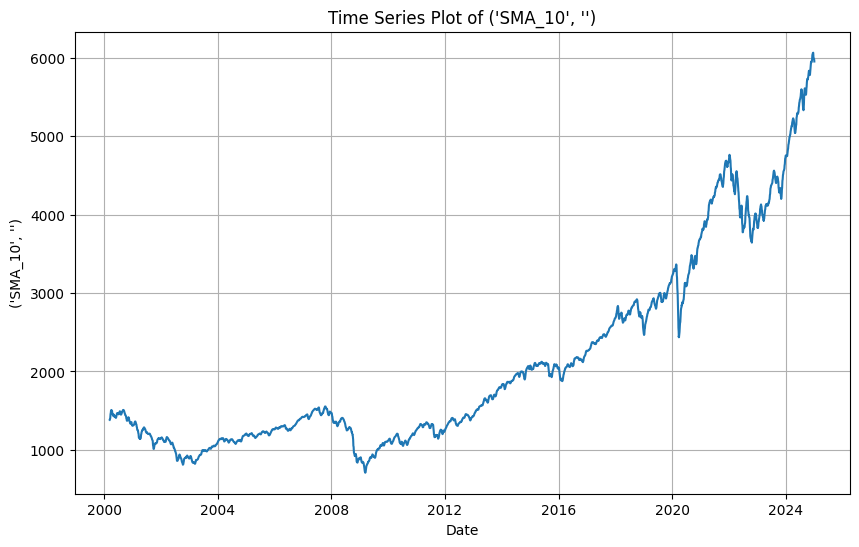

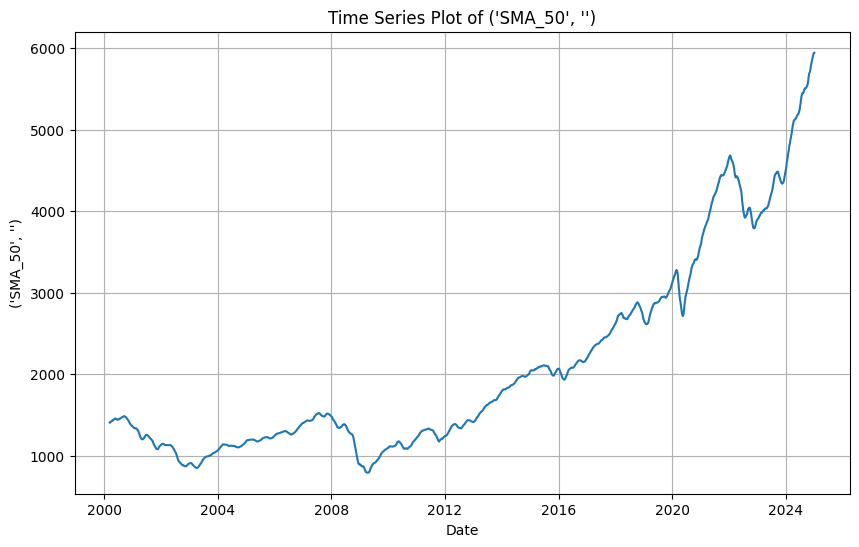

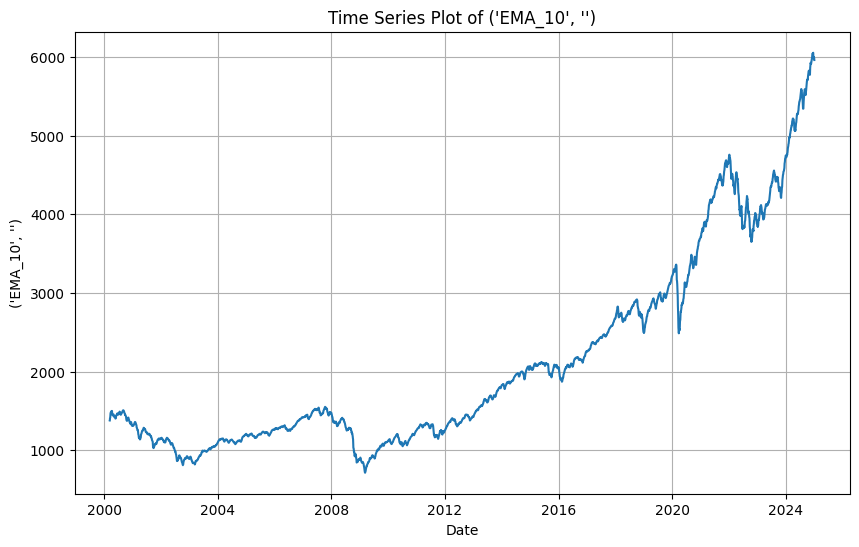

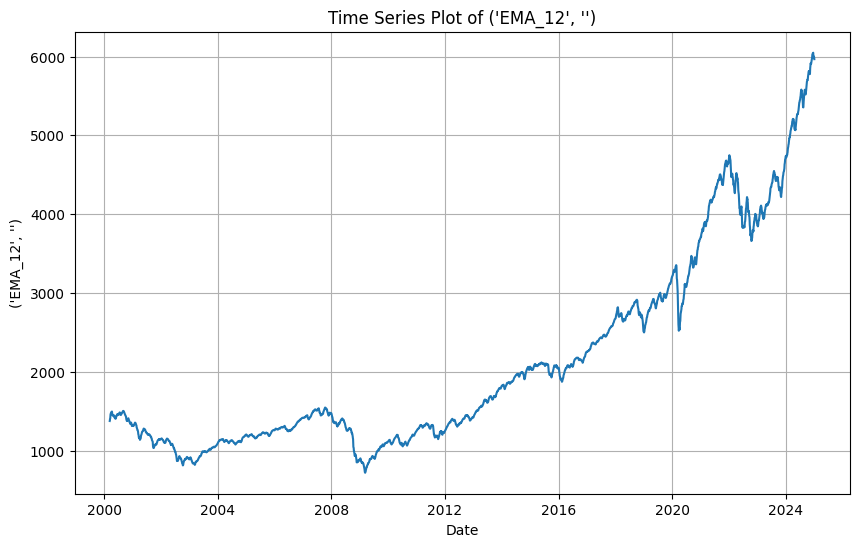

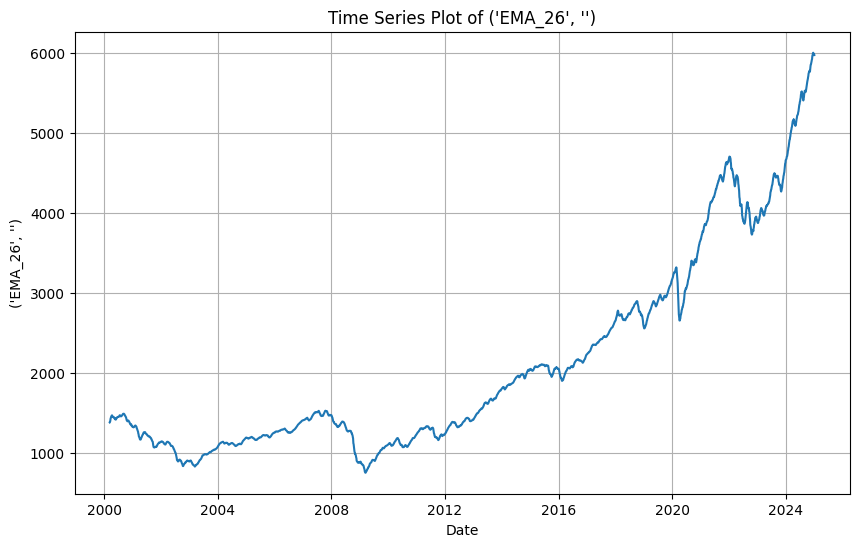

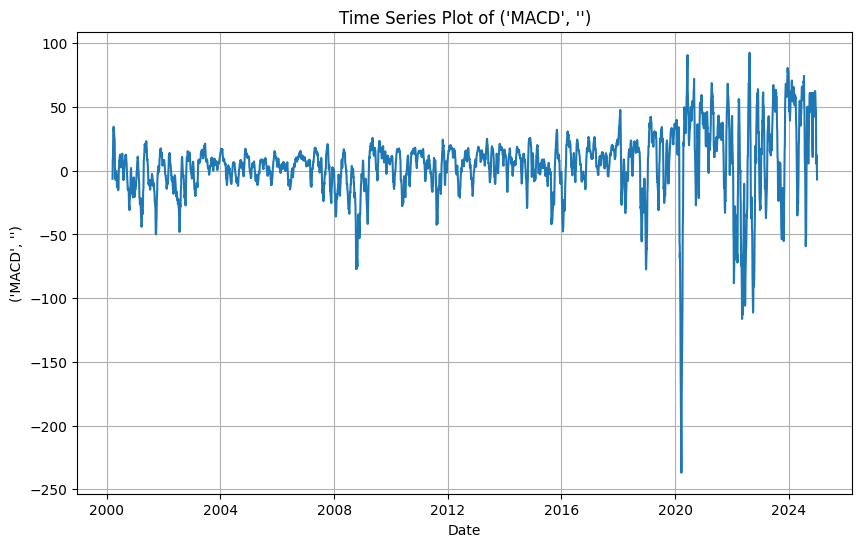

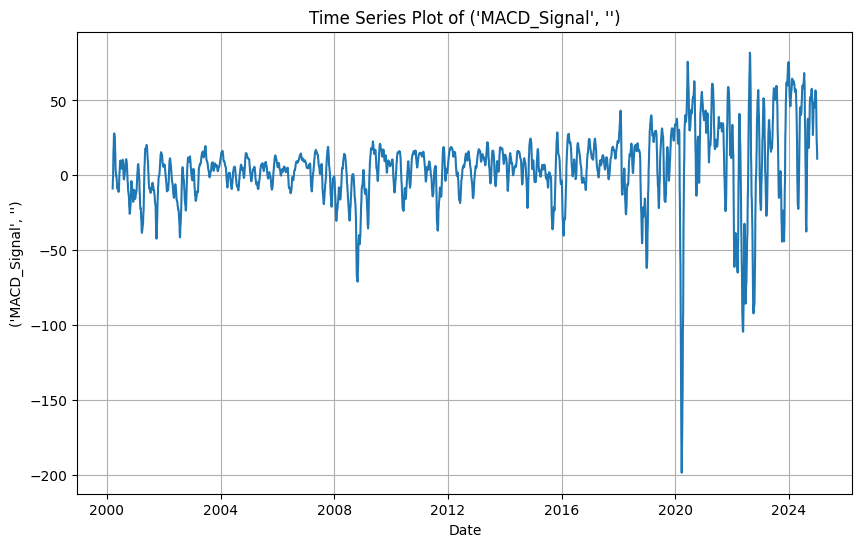

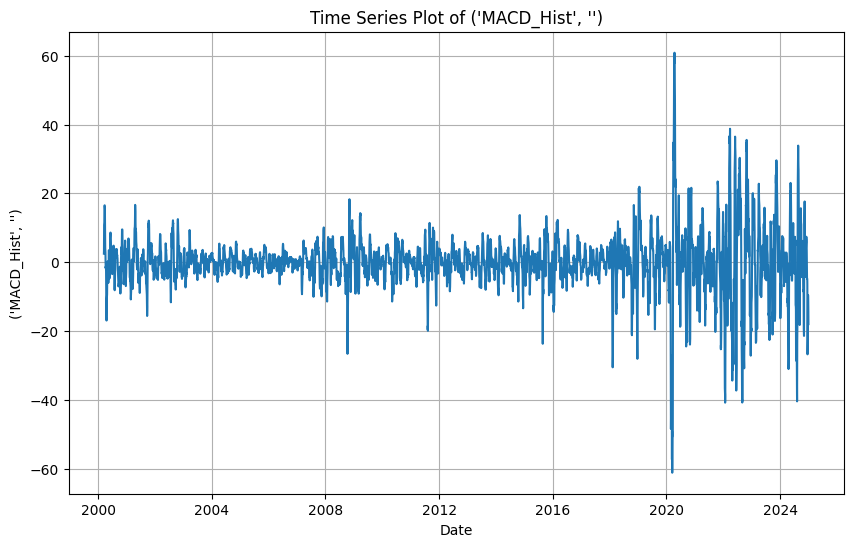

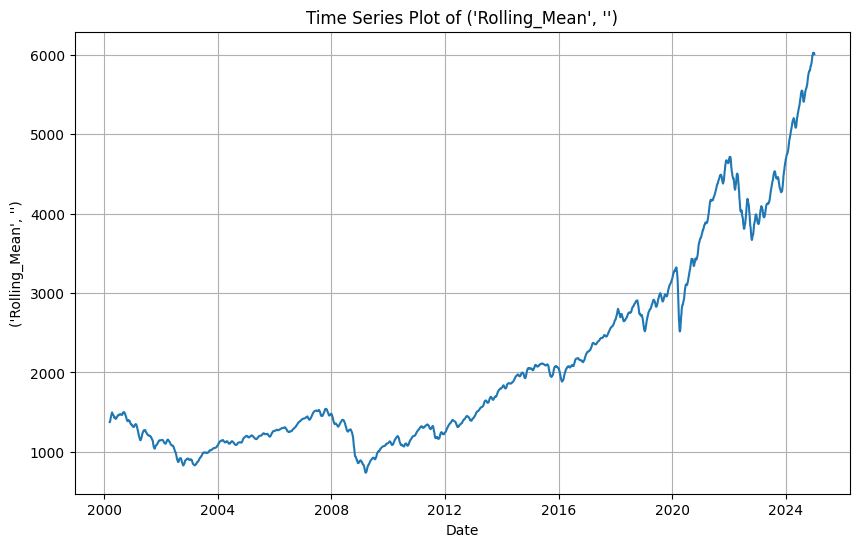

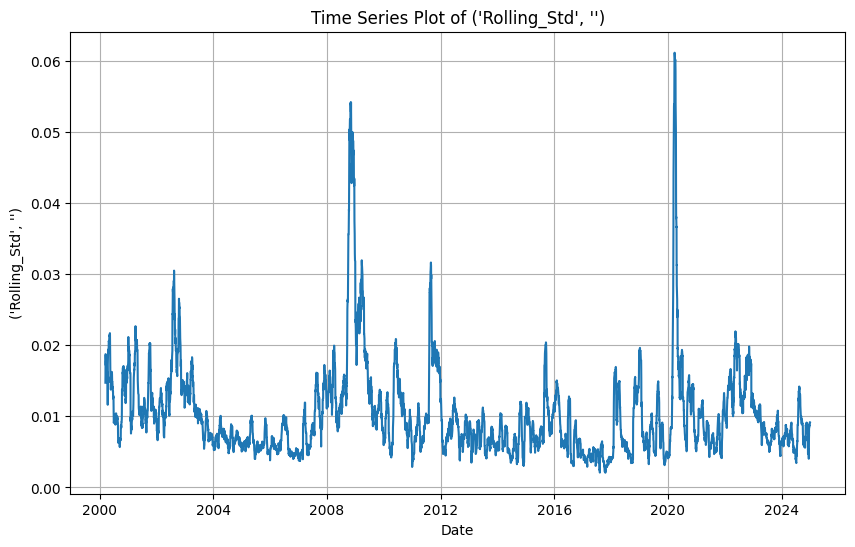

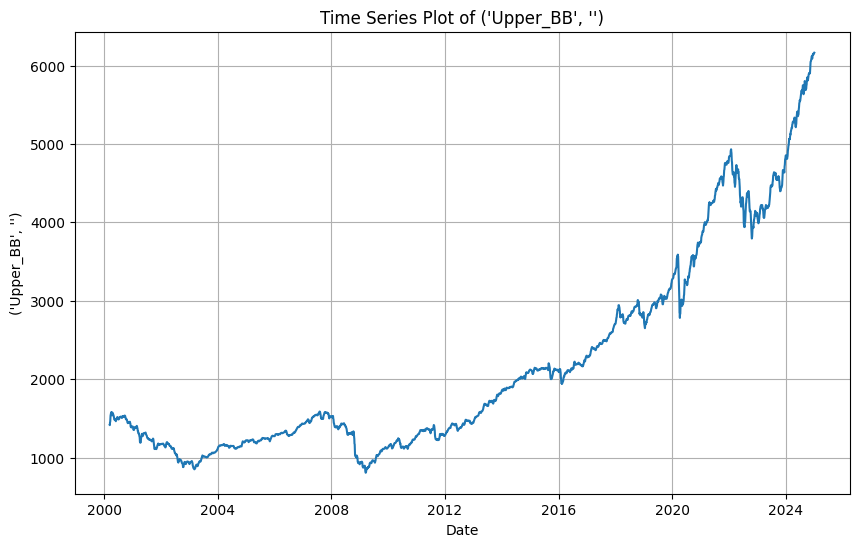

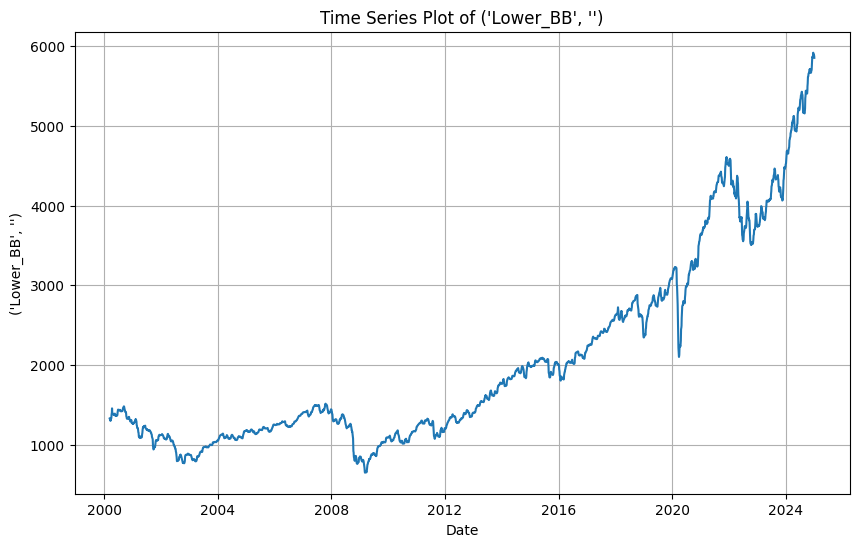

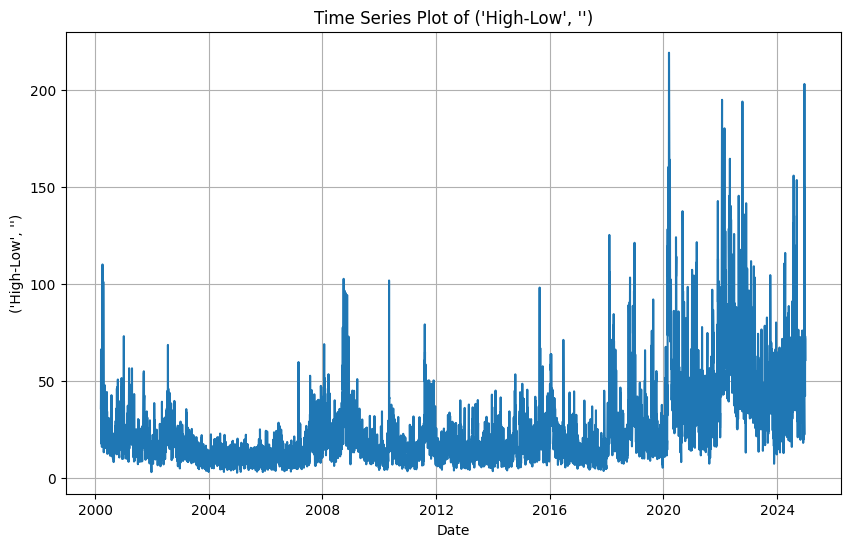

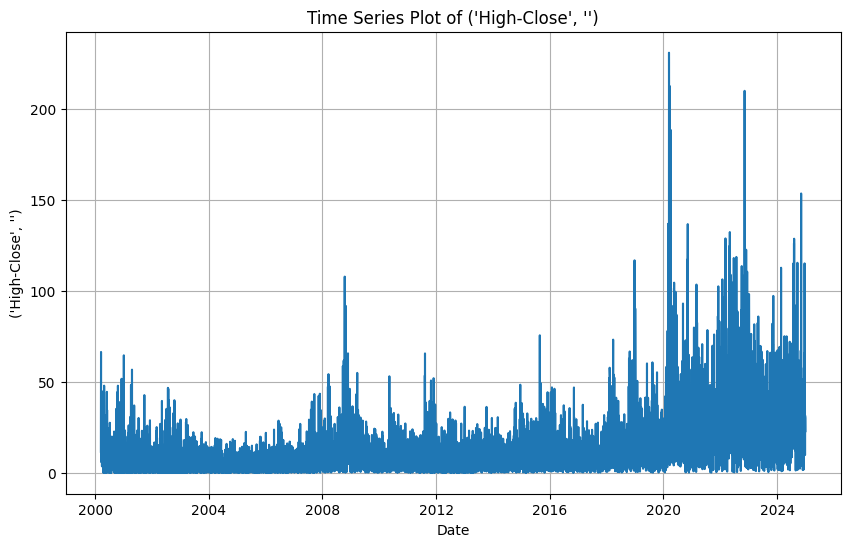

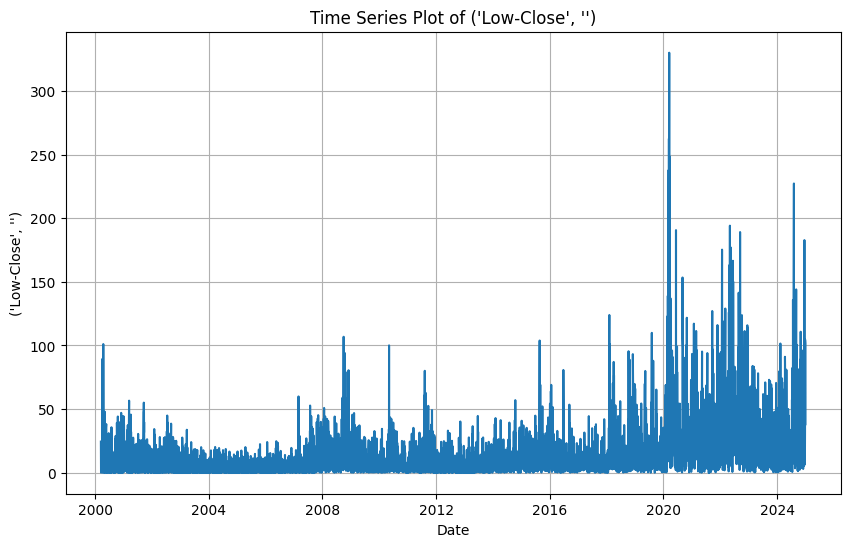

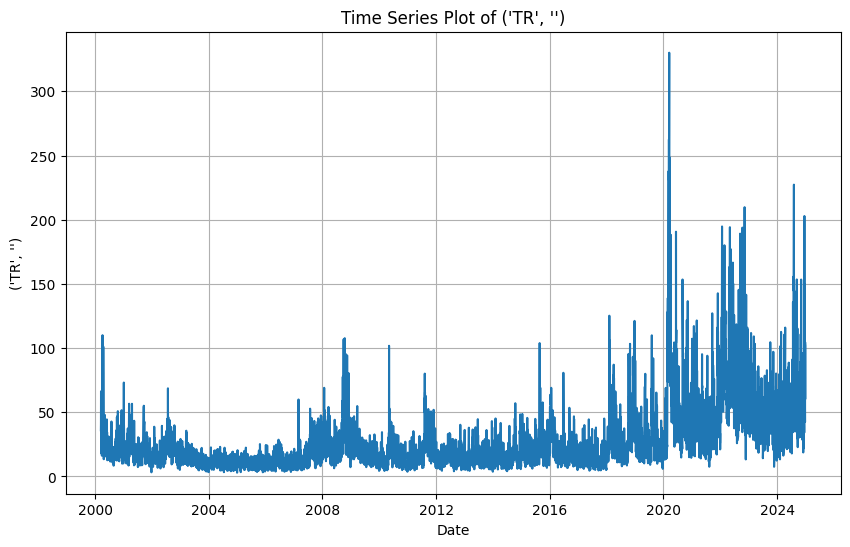

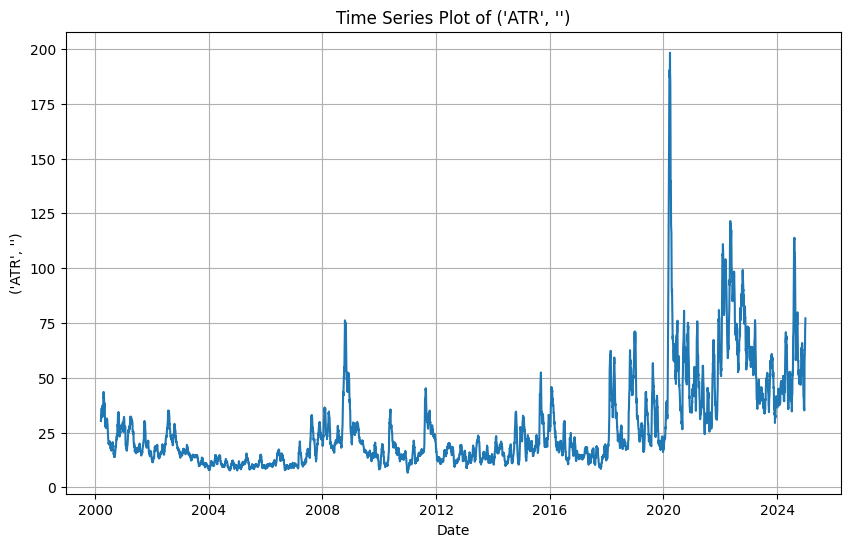

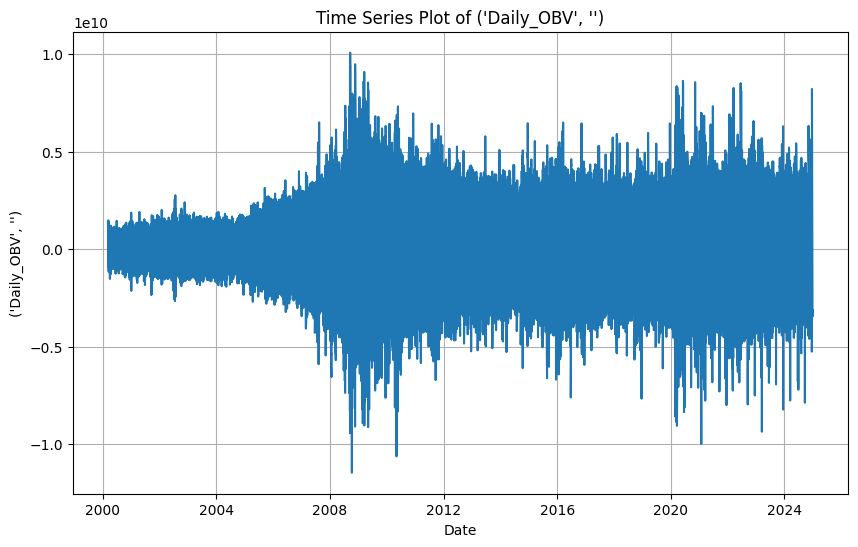

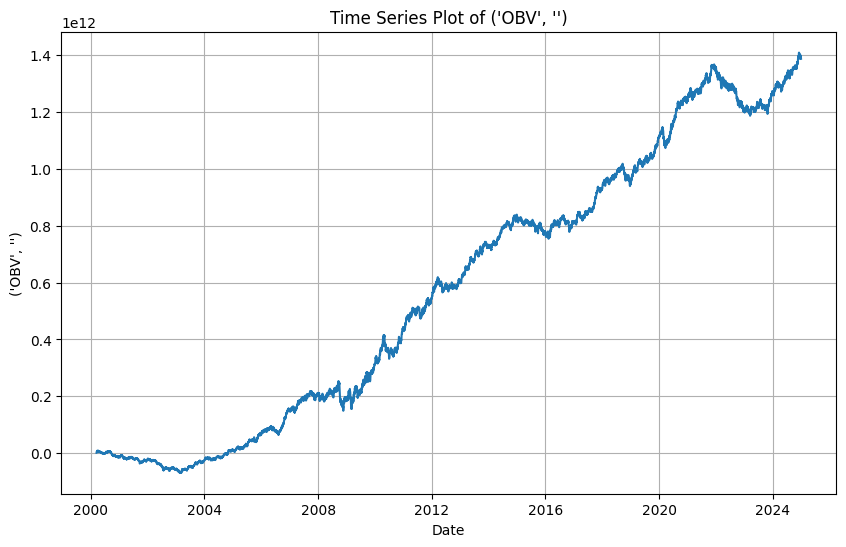

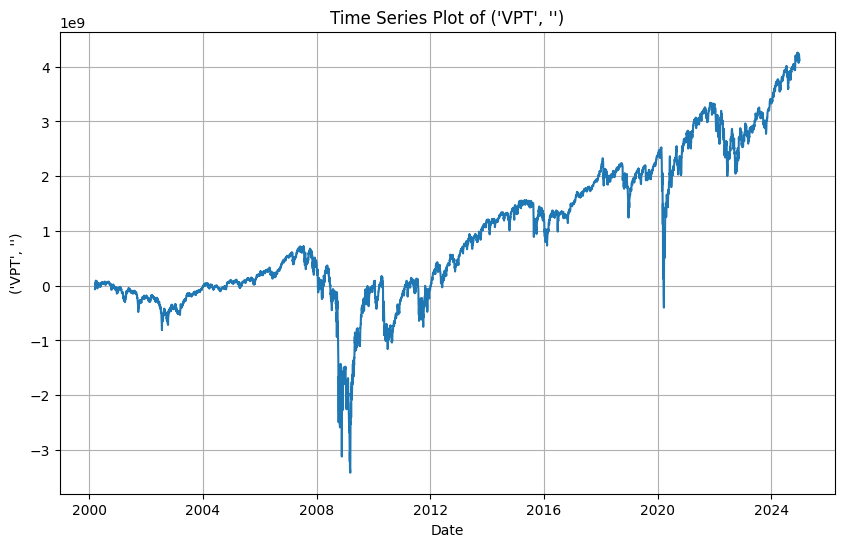

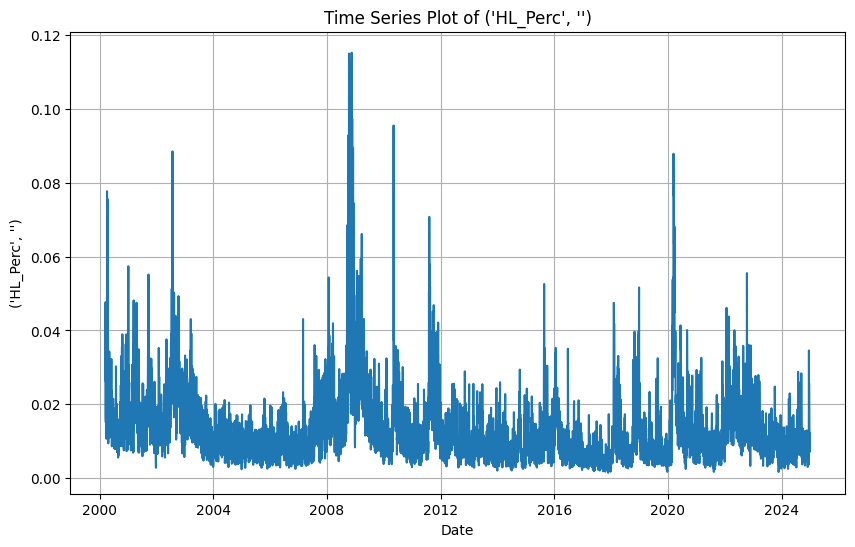

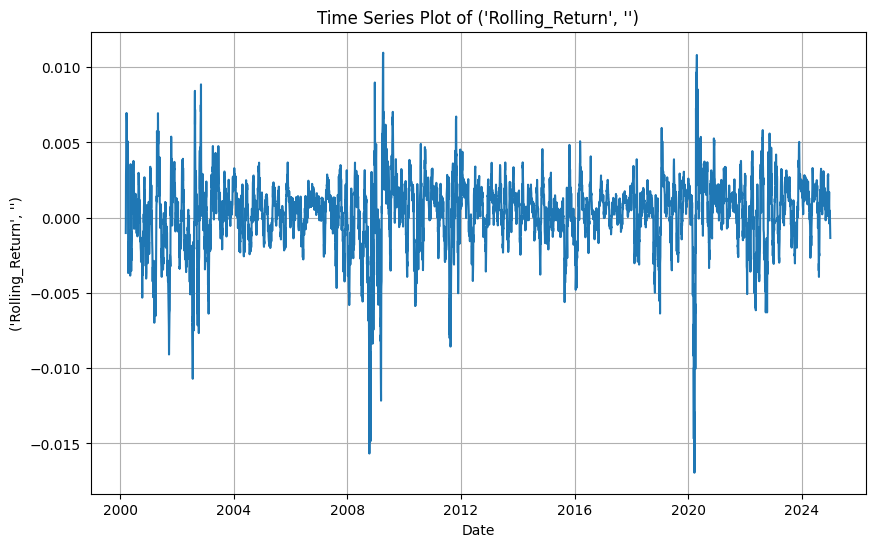

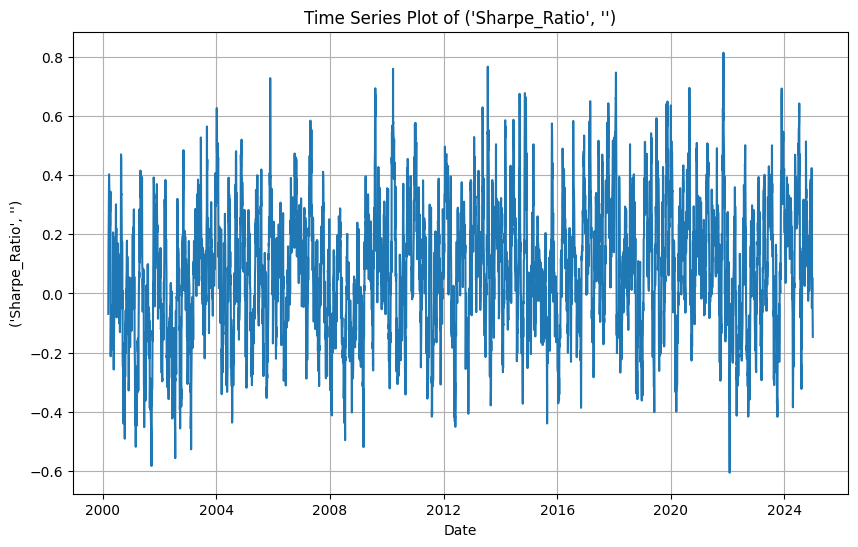

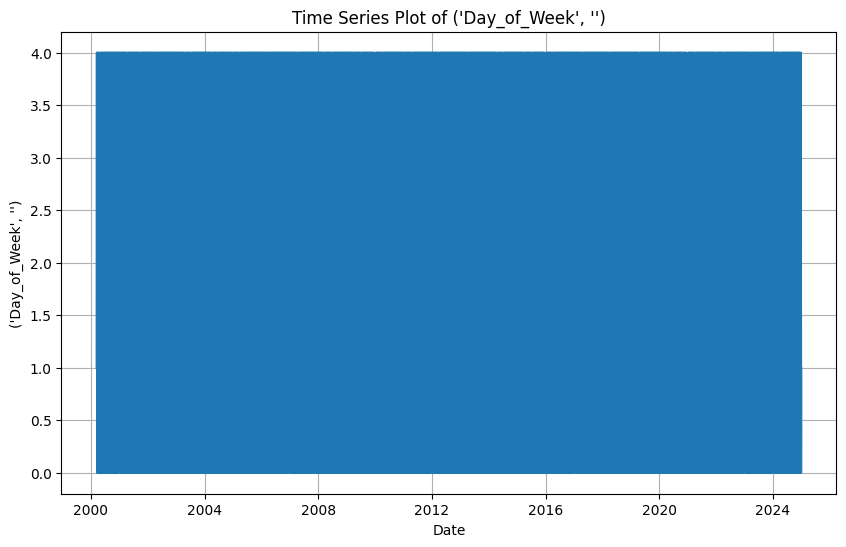

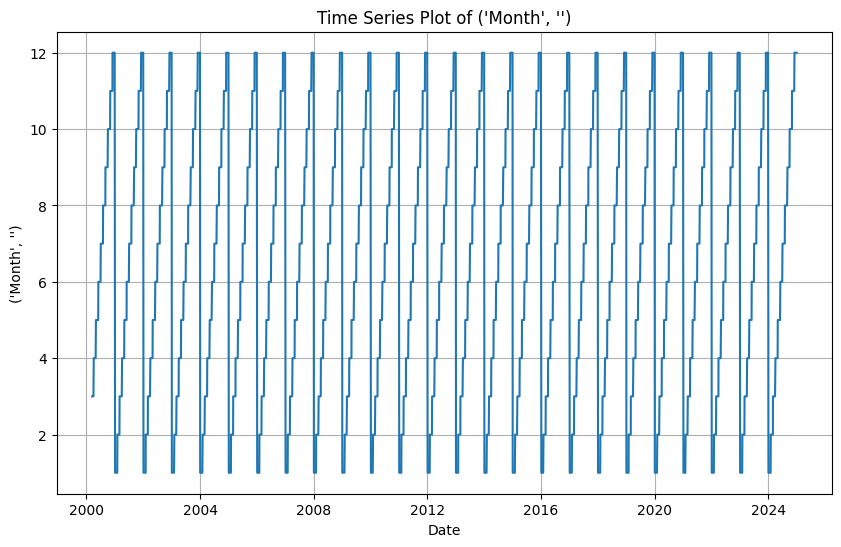

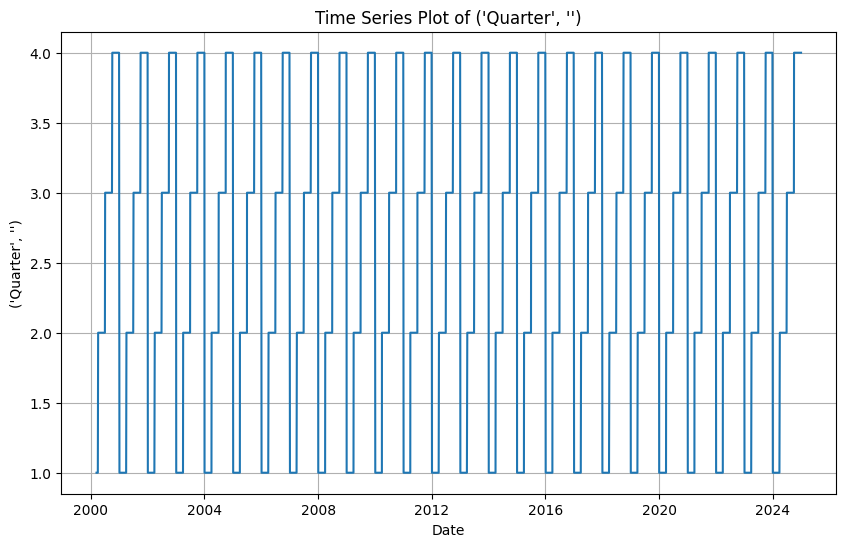

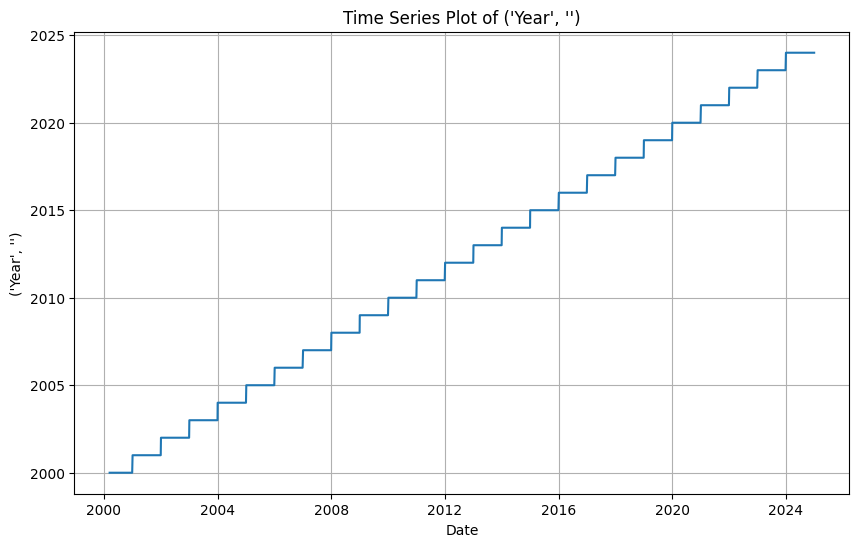

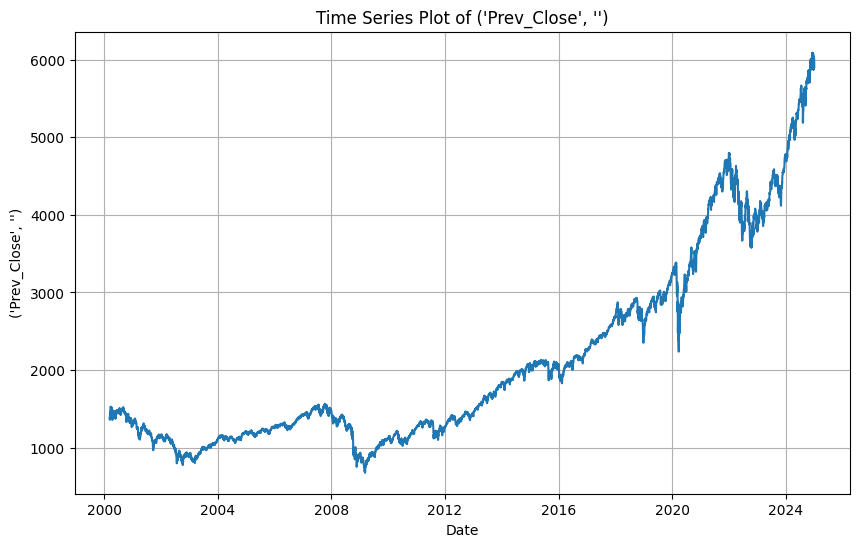

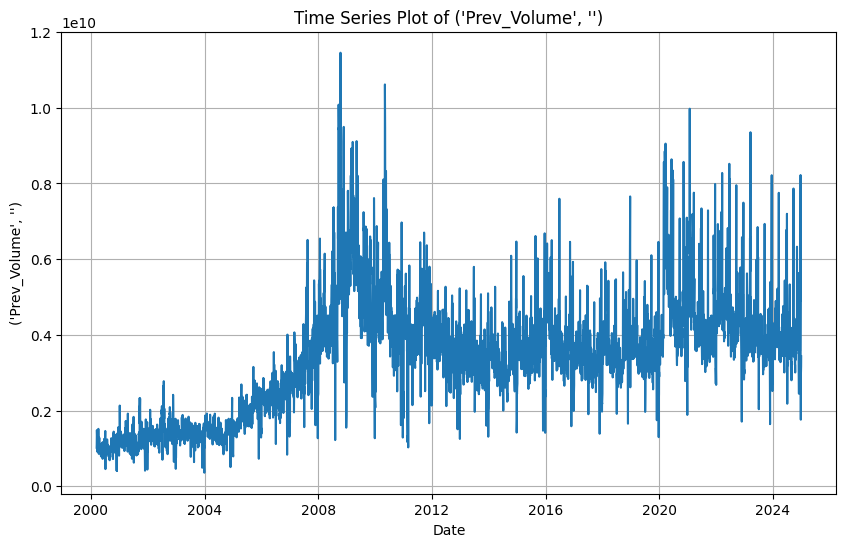

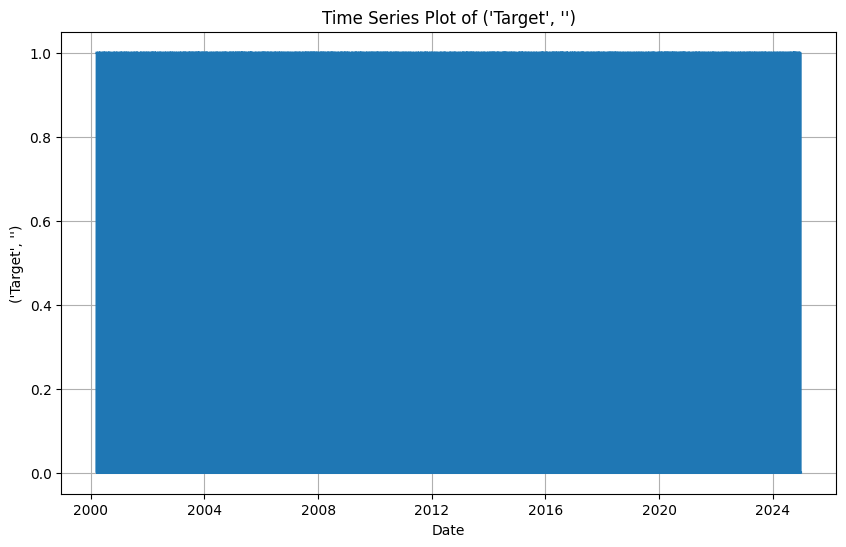

In [ ]:
# prompt: plot the time series plot of df all variable

import matplotlib.pyplot as plt

# Plotting all columns as time series
for column in df1.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(df1.index, df1[column])
    plt.title(f'Time Series Plot of {column}')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.grid(True)
    plt.show()


In [ ]:
df_Time_series = df1[['Close','High','Low','Open','SMA_10','SMA_50','EMA_10','EMA_12','EMA_26','Rolling_Mean','Upper_BB','Lower_BB','OBV','VPT','Prev_Close']]

In [ ]:
df_Start_input = df1.drop(['Close','High','Low','Open','SMA_10','SMA_50','EMA_10','EMA_12','EMA_26','Rolling_Mean','Upper_BB','Lower_BB','OBV','VPT','Prev_Close'], axis=1)

In [ ]:
X_train = pd.DataFrame(df_Time_series['Close'][0: int(len(df_Time_series)*0.80)])
X_test = pd.DataFrame(df_Time_series['Close'][int(len(df_Time_series)*0.80):int(len(df_Time_series))])
print(X_train.shape)
print(X_test.shape)

(4992, 1)
(1248, 1)


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
scaled_data = scaler.fit_transform(X_train)
scaled_data

array([[0.26126395],
       [0.27389044],
       [0.29927737],
       ...,
       [0.99955597],
       [0.99764994],
       [1.        ]])

In [ ]:
scaled_data_test = scaler.fit_transform(X_test)
scaled_data_test

array([[0.28015742],
       [0.28348223],
       [0.28119041],
       ...,
       [0.96900228],
       [0.95241727],
       [0.94584813]])

In [ ]:
x_train = []
y_train = []
roll_back = 28
for i in range(roll_back, scaled_data.shape[0]):
    x_train.append(scaled_data[i-roll_back: i])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((4964, 28, 1), (4964,))

In [ ]:
x_test = []
y_test = []
for i in range(roll_back, scaled_data_test.shape[0]):
    x_test.append(scaled_data_test[i-roll_back: i])
    y_test.append(scaled_data_test[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((1220, 28, 1), (1220,))

In [ ]:
# Build the LSTM model
model_close = tf.keras.models.Sequential()
model_close.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_close.add(tf.keras.layers.Dropout(0.2))
model_close.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True))
model_close.add(tf.keras.layers.Dropout(0.2))
model_close.add(tf.keras.layers.LSTM(units=roll_back))
model_close.add(tf.keras.layers.Dropout(0.2))
model_close.add(tf.keras.layers.Dense(units=1))  # Output layer for predicting the 'Close' price

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model_close.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model_close.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 28, 28)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 28, 28)              │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 28)                  │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              29 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,157 (63.11 KB)

 Trainable params: 16,157 (63.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model_close.fit(x_train, y_train, epochs=25, batch_size=32,verbose=1) # Adjust epochs and batch_size as needed

Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - loss: 0.0302
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0027
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0024
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0020
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0019
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0018
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0017
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0014
Epoch 9/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0015
Epoch 10/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0014
Epoch 11/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0013
Epoch 12/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0010
Epoch 13/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0011
Epoch 14/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0011
Epoch 15/25
156/156 ━━━━━━━━━━━━━━━━━━

In [ ]:
# Make predictions
predictions = model_close.predict(x_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), x_test.shape[2] -1))), axis=1))[:, 0]

# Evaluate the model
rmse = np.sqrt(np.mean(np.square(predictions - scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_test.shape[2] -1))), axis=1))[:, 0])))
print(f"RMSE: {rmse}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
RMSE: 102.77707453845757


In [ ]:
r2 = r2_score(scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0], predictions)
print(f"R-squared: {r2}")


R-squared: 0.9816861094112482


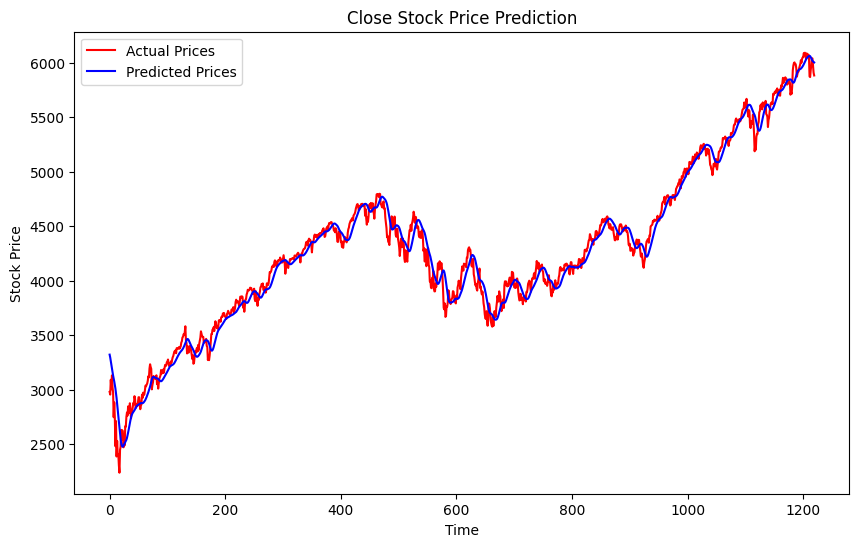

In [ ]:
# Assuming 'predictions' and 'y_test' are defined from the previous code
actual_prices = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0]


plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='red', label='Actual Prices')
plt.plot(predictions, color='blue', label='Predicted Prices')
plt.title('Close Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
X_train = pd.DataFrame(df_Time_series['Open'][0: int(len(df_Time_series)*0.80)])
X_test = pd.DataFrame(df_Time_series['Open'][int(len(df_Time_series)*0.80):int(len(df_Time_series))])
print(X_train.shape)
print(X_test.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(X_train)
scaled_data
scaled_data_test = scaler.fit_transform(X_test)
scaled_data_test

(4992, 1)
(1248, 1)


array([[0.26650205],
       [0.27194918],
       [0.2712568 ],
       ...,
       [0.97818513],
       [0.95567517],
       [0.95543041]])

In [ ]:
x_train = []
y_train = []
roll_back = 28
for i in range(roll_back, scaled_data.shape[0]):
    x_train.append(scaled_data[i-roll_back: i])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((4964, 28, 1), (4964,))

In [ ]:
x_test = []
y_test = []
for i in range(roll_back, scaled_data_test.shape[0]):
    x_test.append(scaled_data_test[i-roll_back: i])
    y_test.append(scaled_data_test[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((1220, 28, 1), (1220,))

In [ ]:
# Build the LSTM model
model_Open = tf.keras.models.Sequential()
model_Open.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_Open.add(tf.keras.layers.Dropout(0.2))
model_Open.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True))
model_Open.add(tf.keras.layers.Dropout(0.2))
model_Open.add(tf.keras.layers.LSTM(units=roll_back))
model_Open.add(tf.keras.layers.Dropout(0.2))
model_Open.add(tf.keras.layers.Dense(units=1))  # Output layer for predicting the 'Open' price

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model_Open.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model_Open.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 28, 28)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 28, 28)              │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 28)                  │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              29 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,157 (63.11 KB)

 Trainable params: 16,157 (63.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model_Open.fit(x_train, y_train,validation_data = [x_test,y_test], epochs=25, batch_size=32,verbose=1) # Adjust epochs and batch_size as needed

Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 0.0211 - val_loss: 0.0018
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 9/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 11/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 12/25
156/156 ━━━━━━━━━━━━━━━

In [ ]:
# Make predictions
predictions = model_Open.predict(x_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), x_test.shape[2] -1))), axis=1))[:, 0]

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [ ]:
# Evaluate the model
rmse = np.sqrt(np.mean(np.square(predictions - scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_test.shape[2] -1))), axis=1))[:, 0])))
print(f"RMSE: {rmse}")

RMSE: 167.00366969477312


In [ ]:
r2 = r2_score(scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0], predictions)
print(f"R-squared: {r2}")

R-squared: 0.9516659846351585


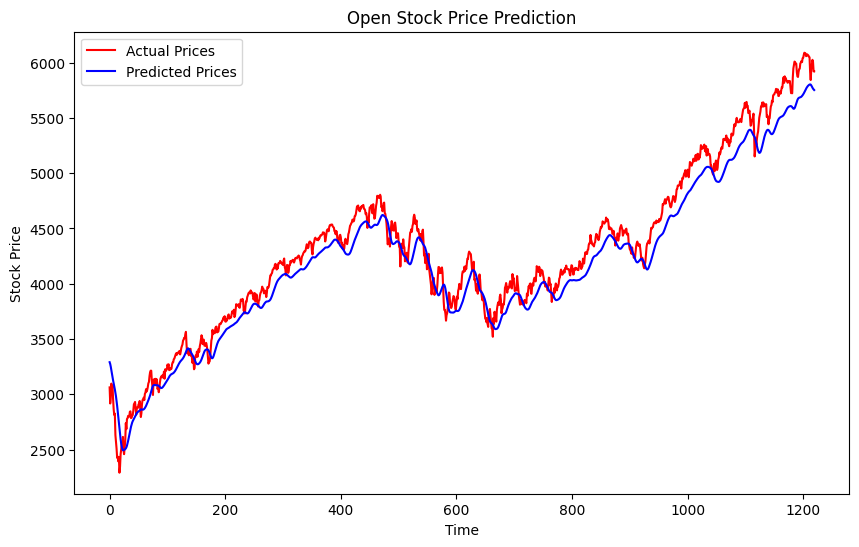

In [ ]:
# Assuming 'predictions' and 'y_test' are defined from the previous code
actual_prices = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0]


plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='red', label='Actual Prices')
plt.plot(predictions, color='blue', label='Predicted Prices')
plt.title('Open Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
X_train = pd.DataFrame(df_Time_series['High'][0: int(len(df_Time_series)*0.80)])
X_test = pd.DataFrame(df_Time_series['High'][int(len(df_Time_series)*0.80):int(len(df_Time_series))])
print(X_train.shape)
print(X_test.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(X_train)
scaled_data
scaled_data_test = scaler.fit_transform(X_test)
scaled_data_test

(4992, 1)
(1248, 1)


array([[0.26752194],
       [0.27088308],
       [0.27085943],
       ...,
       [0.97531078],
       [0.9581021 ],
       [0.95519368]])

In [ ]:
x_train = []
y_train = []
roll_back = 28
for i in range(roll_back, scaled_data.shape[0]):
    x_train.append(scaled_data[i-roll_back: i])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((4964, 28, 1), (4964,))

In [ ]:
x_test = []
y_test = []
for i in range(roll_back, scaled_data_test.shape[0]):
    x_test.append(scaled_data_test[i-roll_back: i])
    y_test.append(scaled_data_test[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((1220, 28, 1), (1220,))

In [ ]:
# Build the LSTM model
model_High = tf.keras.models.Sequential()
model_High.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_High.add(tf.keras.layers.Dropout(0.2))
model_High.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True))
model_High.add(tf.keras.layers.Dropout(0.2))
model_High.add(tf.keras.layers.LSTM(units=roll_back))
model_High.add(tf.keras.layers.Dropout(0.2))
model_High.add(tf.keras.layers.Dense(units=1))  # Output layer for predicting the 'High' price

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model_High.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model_High.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 28, 28)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 28, 28)              │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 28)                  │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              29 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,157 (63.11 KB)

 Trainable params: 16,157 (63.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model_High.fit(x_train, y_train,validation_data = [x_test,y_test], epochs=25, batch_size=32,verbose=1) # Adjust epochs and batch_size as needed

Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0317 - val_loss: 0.0026
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.0013 - val_loss: 9.5661e-04
Epoch 11/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 12/25
156/156 ━━━━━━━━━━━

In [ ]:
# Make predictions
predictions = model_High.predict(x_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), x_test.shape[2] -1))), axis=1))[:, 0]

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [ ]:
# Evaluate the model
rmse = np.sqrt(np.mean(np.square(predictions - scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_test.shape[2] -1))), axis=1))[:, 0])))
print(f"RMSE: {rmse}")

RMSE: 100.33567941177931


In [ ]:
r2 = r2_score(scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0], predictions)
print(f"R-squared: {r2}")

R-squared: 0.9824336822521451


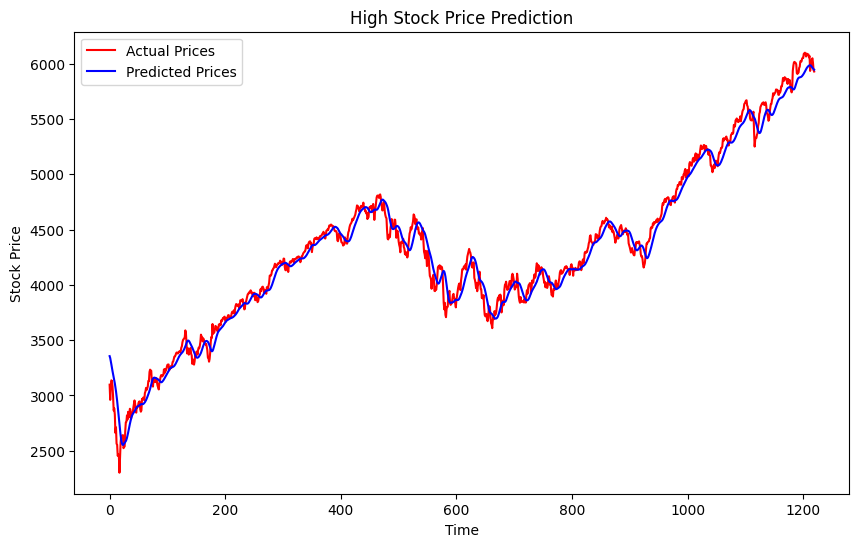

In [ ]:
# Assuming 'predictions' and 'y_test' are defined from the previous code
actual_prices = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0]


plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='red', label='Actual Prices')
plt.plot(predictions, color='blue', label='Predicted Prices')
plt.title('High Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
X_train = pd.DataFrame(df_Time_series['Low'][0: int(len(df_Time_series)*0.80)])
X_test = pd.DataFrame(df_Time_series['Low'][int(len(df_Time_series)*0.80):int(len(df_Time_series))])
print(X_train.shape)
print(X_test.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(X_train)
scaled_data
scaled_data_test = scaler.fit_transform(X_test)
scaled_data_test

(4992, 1)
(1248, 1)


array([[0.28573192],
       [0.28985732],
       [0.28927863],
       ...,
       [0.96218486],
       [0.94577847],
       [0.94570123]])

In [ ]:
x_train = []
y_train = []
roll_back = 28
for i in range(roll_back, scaled_data.shape[0]):
    x_train.append(scaled_data[i-roll_back: i])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((4964, 28, 1), (4964,))

In [ ]:
x_test = []
y_test = []
for i in range(roll_back, scaled_data_test.shape[0]):
    x_test.append(scaled_data_test[i-roll_back: i])
    y_test.append(scaled_data_test[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((1220, 28, 1), (1220,))

In [ ]:
# Build the LSTM model
model_Low = tf.keras.models.Sequential()
model_Low.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_Low.add(tf.keras.layers.Dropout(0.2))
model_Low.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True))
model_Low.add(tf.keras.layers.Dropout(0.2))
model_Low.add(tf.keras.layers.LSTM(units=roll_back))
model_Low.add(tf.keras.layers.Dropout(0.2))
model_Low.add(tf.keras.layers.Dense(units=1))  # Output layer for predicting the 'Low' price

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model_Low.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model_Low.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 28, 28)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 28, 28)              │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 28)                  │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              29 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,157 (63.11 KB)

 Trainable params: 16,157 (63.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model_Low.fit(x_train, y_train,validation_data = [x_test,y_test], epochs=25, batch_size=32,verbose=1) # Adjust epochs and batch_size as needed

Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0246 - val_loss: 0.0026
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0022 - val_loss: 0.0043
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 11/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 12/25
156/156 ━━━━━━━━━━━━━━━━

In [ ]:
# Make predictions
predictions = model_Low.predict(x_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), x_test.shape[2] -1))), axis=1))[:, 0]

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


In [ ]:
# Evaluate the model
rmse = np.sqrt(np.mean(np.square(predictions - scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_test.shape[2] -1))), axis=1))[:, 0])))
print(f"RMSE: {rmse}")

RMSE: 124.21568118032613


In [ ]:
r2 = r2_score(scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0], predictions)
print(f"R-squared: {r2}")

R-squared: 0.9734450889685573


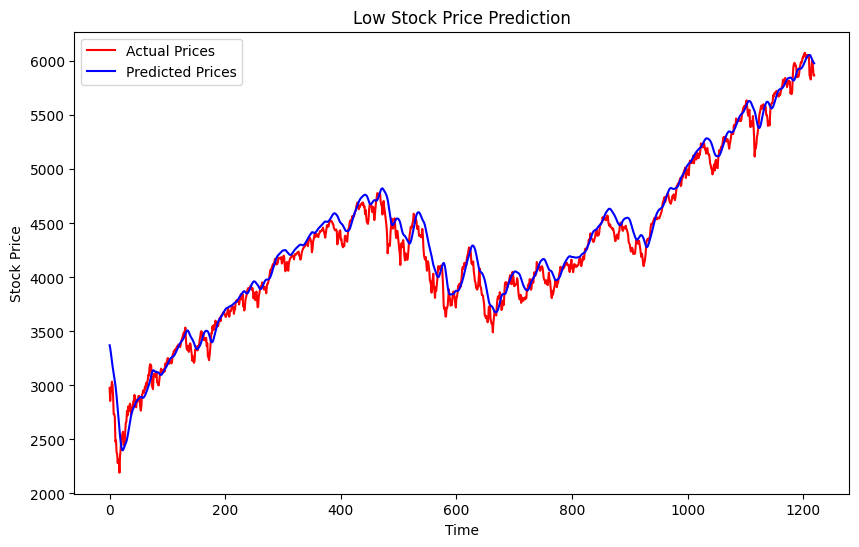

In [ ]:
# Assuming 'predictions' and 'y_test' are defined from the previous code
actual_prices = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0]


plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='red', label='Actual Prices')
plt.plot(predictions, color='blue', label='Predicted Prices')
plt.title('Low Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
X_train = pd.DataFrame(df_Time_series['SMA_10'][0: int(len(df_Time_series)*0.80)])
X_test = pd.DataFrame(df_Time_series['SMA_10'][int(len(df_Time_series)*0.80):int(len(df_Time_series))])
print(X_train.shape)
print(X_test.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(X_train)
scaled_data
scaled_data_test = scaler.fit_transform(X_test)
scaled_data_test

(4992, 1)
(1248, 1)


array([[0.22951045],
       [0.23212182],
       [0.23417493],
       ...,
       [0.97843999],
       [0.97446797],
       [0.96916504]])

In [ ]:
x_train = []
y_train = []
roll_back = 28
for i in range(roll_back, scaled_data.shape[0]):
    x_train.append(scaled_data[i-roll_back: i])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((4964, 28, 1), (4964,))

In [ ]:
x_test = []
y_test = []
for i in range(roll_back, scaled_data_test.shape[0]):
    x_test.append(scaled_data_test[i-roll_back: i])
    y_test.append(scaled_data_test[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((1220, 28, 1), (1220,))

In [ ]:
# Build the LSTM model
model_SMA_10 = tf.keras.models.Sequential()
model_SMA_10.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_SMA_10.add(tf.keras.layers.Dropout(0.2))
model_SMA_10.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True))
model_SMA_10.add(tf.keras.layers.Dropout(0.2))
model_SMA_10.add(tf.keras.layers.LSTM(units=roll_back))
model_SMA_10.add(tf.keras.layers.Dropout(0.2))
model_SMA_10.add(tf.keras.layers.Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model_SMA_10.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model_SMA_10.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 28, 28)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 28, 28)              │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 28)                  │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              29 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,157 (63.11 KB)

 Trainable params: 16,157 (63.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model_SMA_10.fit(x_train, y_train,validation_data = [x_test,y_test], epochs=25, batch_size=32,verbose=1) # Adjust epochs and batch_size as needed

Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 0.0346 - val_loss: 0.0028
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0018 - val_loss: 9.5972e-04
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0018 - val_loss: 9.4973e-04
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 9/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 10/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 11/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 12/25
156/156 ━━━━━━━━━

In [ ]:
# Make predictions
predictions = model_SMA_10.predict(x_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), x_test.shape[2] -1))), axis=1))[:, 0]

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [ ]:
# Evaluate the model
rmse = np.sqrt(np.mean(np.square(predictions - scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_test.shape[2] -1))), axis=1))[:, 0])))
print(f"RMSE: {rmse}")

RMSE: 110.88433896556955


In [ ]:
r2 = r2_score(scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0], predictions)
print(f"R-squared: {r2}")

R-squared: 0.9783129722544299


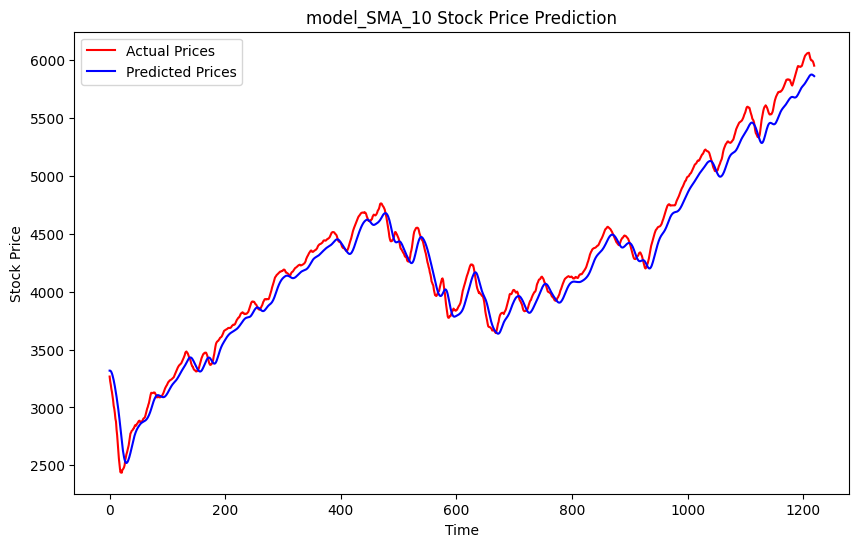

In [ ]:
# Assuming 'predictions' and 'y_test' are defined from the previous code
actual_prices = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0]


plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='red', label='Actual Prices')
plt.plot(predictions, color='blue', label='Predicted Prices')
plt.title('model_SMA_10 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
X_train = pd.DataFrame(df_Time_series['SMA_50'][0: int(len(df_Time_series)*0.80)])
X_test = pd.DataFrame(df_Time_series['SMA_50'][int(len(df_Time_series)*0.80):int(len(df_Time_series))])
print(X_train.shape)
print(X_test.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(X_train)
scaled_data
scaled_data_test = scaler.fit_transform(X_test)
scaled_data_test

(4992, 1)
(1248, 1)


array([[0.14232685],
       [0.14390582],
       [0.14541674],
       ...,
       [0.99948959],
       [0.99989498],
       [1.        ]])

In [ ]:
x_train = []
y_train = []
roll_back = 28
for i in range(roll_back, scaled_data.shape[0]):
    x_train.append(scaled_data[i-roll_back: i])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((4964, 28, 1), (4964,))

In [ ]:
x_test = []
y_test = []
for i in range(roll_back, scaled_data_test.shape[0]):
    x_test.append(scaled_data_test[i-roll_back: i])
    y_test.append(scaled_data_test[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((1220, 28, 1), (1220,))

In [ ]:
# Build the LSTM model
model_SMA_50 = tf.keras.models.Sequential()
model_SMA_50.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_SMA_50.add(tf.keras.layers.Dropout(0.2))
model_SMA_50.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True))
model_SMA_50.add(tf.keras.layers.Dropout(0.2))
model_SMA_50.add(tf.keras.layers.LSTM(units=roll_back))
model_SMA_50.add(tf.keras.layers.Dropout(0.2))
model_SMA_50.add(tf.keras.layers.Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model_SMA_50.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model_SMA_50.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 28, 28)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 28, 28)              │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 28)                  │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              29 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,157 (63.11 KB)

 Trainable params: 16,157 (63.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model_SMA_50.fit(x_train, y_train,validation_data = [x_test,y_test], epochs=25, batch_size=32,verbose=1) # Adjust epochs and batch_size as needed

Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0260 - val_loss: 8.5422e-04
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0025 - val_loss: 0.0010
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0019 - val_loss: 4.8139e-04
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 0.0018 - val_loss: 6.1410e-04
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0017 - val_loss: 5.7953e-04
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0014 - val_loss: 7.3672e-04
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0012 - val_loss: 7.2621e-04
Epoch 9/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - loss: 0.0013 - val_loss: 4.5722e-04
Epoch 10/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - loss: 0.0013 - val_loss: 5.9009e-04
Epoch 11/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0013 - val_loss: 8.6192e-0

In [ ]:
# Make predictions
predictions = model_SMA_50.predict(x_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), x_test.shape[2] -1))), axis=1))[:, 0]

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [ ]:
# Evaluate the model
rmse = np.sqrt(np.mean(np.square(predictions - scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_test.shape[2] -1))), axis=1))[:, 0])))
print(f"RMSE: {rmse}")

RMSE: 62.68688840352028


In [ ]:
r2 = r2_score(scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0], predictions)
print(f"R-squared: {r2}")

R-squared: 0.9924317892698826


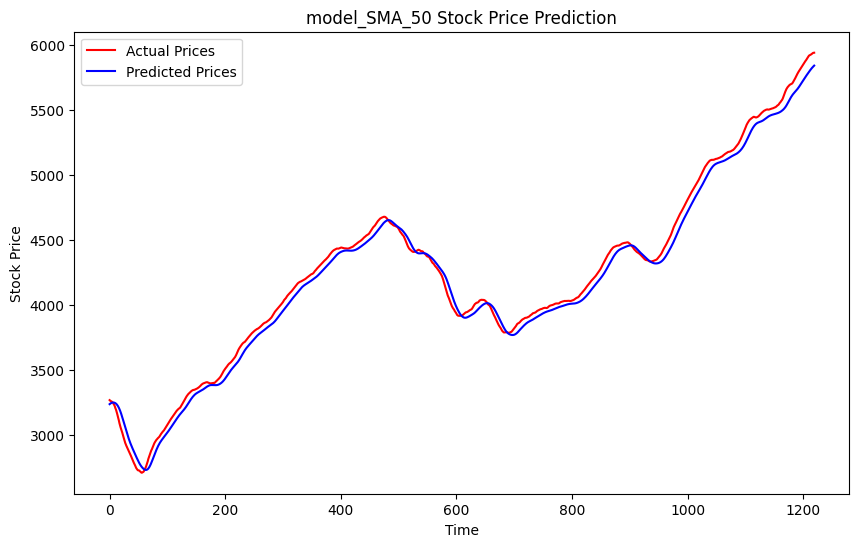

In [ ]:
# Assuming 'predictions' and 'y_test' are defined from the previous code
actual_prices = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0]


plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='red', label='Actual Prices')
plt.plot(predictions, color='blue', label='Predicted Prices')
plt.title('model_SMA_50 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
X_train = pd.DataFrame(df_Time_series['EMA_10'][0: int(len(df_Time_series)*0.80)])
X_test = pd.DataFrame(df_Time_series['EMA_10'][int(len(df_Time_series)*0.80):int(len(df_Time_series))])
print(X_train.shape)
print(X_test.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(X_train)
scaled_data
scaled_data_test = scaler.fit_transform(X_test)
scaled_data_test

(4992, 1)
(1248, 1)


array([[0.22086628],
       [0.22369559],
       [0.2255604 ],
       ...,
       [0.98337452],
       [0.97893218],
       [0.97400748]])

In [ ]:
x_train = []
y_train = []
roll_back = 28
for i in range(roll_back, scaled_data.shape[0]):
    x_train.append(scaled_data[i-roll_back: i])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((4964, 28, 1), (4964,))

In [ ]:
x_test = []
y_test = []
for i in range(roll_back, scaled_data_test.shape[0]):
    x_test.append(scaled_data_test[i-roll_back: i])
    y_test.append(scaled_data_test[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((1220, 28, 1), (1220,))

In [ ]:
# Build the LSTM model
model_EMA_10 = tf.keras.models.Sequential()
model_EMA_10.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_EMA_10.add(tf.keras.layers.Dropout(0.2))
model_EMA_10.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True))
model_EMA_10.add(tf.keras.layers.Dropout(0.2))
model_EMA_10.add(tf.keras.layers.LSTM(units=roll_back))
model_EMA_10.add(tf.keras.layers.Dropout(0.2))
model_EMA_10.add(tf.keras.layers.Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model_EMA_10.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model_EMA_10.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 28, 28)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 28, 28)              │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 28)                  │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              29 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,157 (63.11 KB)

 Trainable params: 16,157 (63.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model_EMA_10.fit(x_train, y_train,validation_data = [x_test,y_test], epochs=25, batch_size=32,verbose=1) # Adjust epochs and batch_size as needed

Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.0276 - val_loss: 0.0041
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 9/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0012 - val_loss: 9.9816e-04
Epoch 11/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 12/25
156/156 ━━━━━━━━━━━━━

In [ ]:
# Make predictions
predictions = model_EMA_10.predict(x_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), x_test.shape[2] -1))), axis=1))[:, 0]

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [ ]:
# Evaluate the model
rmse = np.sqrt(np.mean(np.square(predictions - scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_test.shape[2] -1))), axis=1))[:, 0])))
print(f"RMSE: {rmse}")

RMSE: 80.25739177731383


In [ ]:
r2 = r2_score(scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0], predictions)
print(f"R-squared: {r2}")

R-squared: 0.9885995004339143


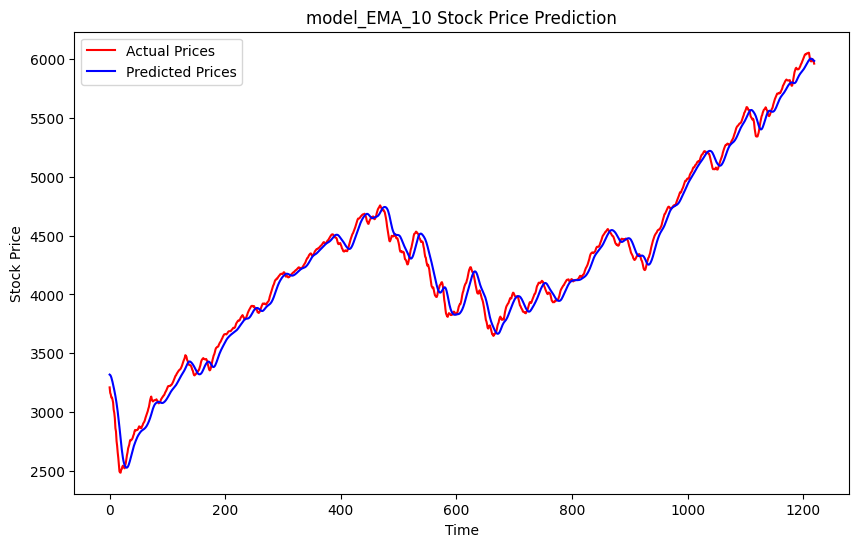

In [ ]:
# Assuming 'predictions' and 'y_test' are defined from the previous code
actual_prices = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0]


plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='red', label='Actual Prices')
plt.plot(predictions, color='blue', label='Predicted Prices')
plt.title('model_EMA_10 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
X_train = pd.DataFrame(df_Time_series['EMA_12'][0: int(len(df_Time_series)*0.80)])
X_test = pd.DataFrame(df_Time_series['EMA_12'][int(len(df_Time_series)*0.80):int(len(df_Time_series))])
print(X_train.shape)
print(X_test.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(X_train)
scaled_data
scaled_data_test = scaler.fit_transform(X_test)
scaled_data_test

(4992, 1)
(1248, 1)


array([[0.21153146],
       [0.21421183],
       [0.21609453],
       ...,
       [0.9851489 ],
       [0.98127055],
       [0.97688448]])

In [ ]:
x_train = []
y_train = []
roll_back = 28
for i in range(roll_back, scaled_data.shape[0]):
    x_train.append(scaled_data[i-roll_back: i])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((4964, 28, 1), (4964,))

In [ ]:
x_test = []
y_test = []
for i in range(roll_back, scaled_data_test.shape[0]):
    x_test.append(scaled_data_test[i-roll_back: i])
    y_test.append(scaled_data_test[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((1220, 28, 1), (1220,))

In [ ]:
# Build the LSTM model
model_EMA_12 = tf.keras.models.Sequential()
model_EMA_12.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_EMA_12.add(tf.keras.layers.Dropout(0.2))
model_EMA_12.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True))
model_EMA_12.add(tf.keras.layers.Dropout(0.2))
model_EMA_12.add(tf.keras.layers.LSTM(units=roll_back))
model_EMA_12.add(tf.keras.layers.Dropout(0.2))
model_EMA_12.add(tf.keras.layers.Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model_EMA_12.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model_EMA_12.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                       │ (None, 28, 28)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 28, 28)              │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 28)                  │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              29 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,157 (63.11 KB)

 Trainable params: 16,157 (63.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model_EMA_12.fit(x_train, y_train,validation_data = [x_test,y_test], epochs=25, batch_size=32,verbose=1) # Adjust epochs and batch_size as needed

Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 0.0246 - val_loss: 0.0011
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0026 - val_loss: 9.8789e-04
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0015 - val_loss: 8.8195e-04
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0013 - val_loss: 9.7367e-04
Epoch 9/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0014 - val_loss: 8.2481e-04
Epoch 10/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0013 - val_loss: 9.4373e-04
Epoch 11/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 12/25
15

In [ ]:
# Make predictions
predictions = model_EMA_12.predict(x_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), x_test.shape[2] -1))), axis=1))[:, 0]

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [ ]:
# Evaluate the model
rmse = np.sqrt(np.mean(np.square(predictions - scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_test.shape[2] -1))), axis=1))[:, 0])))
print(f"RMSE: {rmse}")

RMSE: 100.0180335026572


In [ ]:
r2 = r2_score(scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0], predictions)
print(f"R-squared: {r2}")

R-squared: 0.9822094377127304


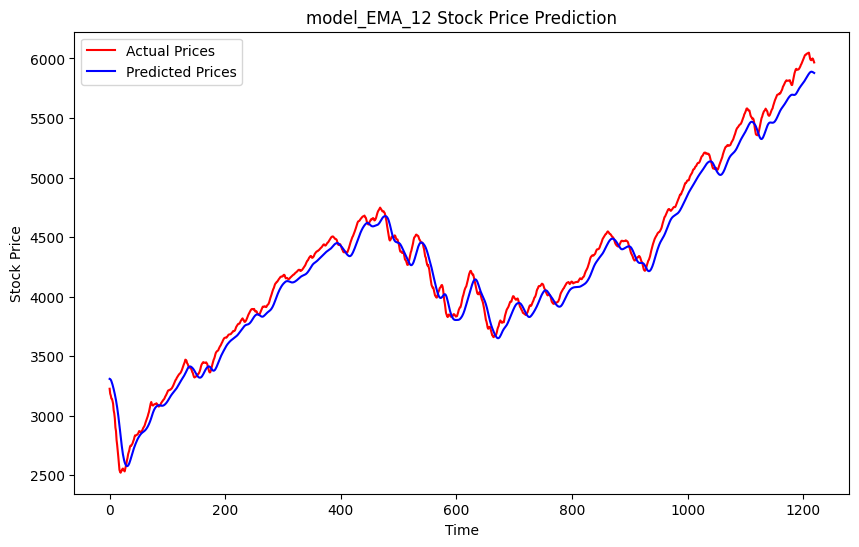

In [ ]:
# Assuming 'predictions' and 'y_test' are defined from the previous code
actual_prices = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0]


plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='red', label='Actual Prices')
plt.plot(predictions, color='blue', label='Predicted Prices')
plt.title('model_EMA_12 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
X_train = pd.DataFrame(df_Time_series['EMA_26'][0: int(len(df_Time_series)*0.80)])
X_test = pd.DataFrame(df_Time_series['EMA_26'][int(len(df_Time_series)*0.80):int(len(df_Time_series))])
print(X_train.shape)
print(X_test.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(X_train)
scaled_data
scaled_data_test = scaler.fit_transform(X_test)
scaled_data_test

(4992, 1)
(1248, 1)


array([[0.17139464],
       [0.17357752],
       [0.17540321],
       ...,
       [0.9951202 ],
       [0.99335061],
       [0.99115171]])

In [ ]:
x_train = []
y_train = []
roll_back = 28
for i in range(roll_back, scaled_data.shape[0]):
    x_train.append(scaled_data[i-roll_back: i])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((4964, 28, 1), (4964,))

In [ ]:
x_test = []
y_test = []
for i in range(roll_back, scaled_data_test.shape[0]):
    x_test.append(scaled_data_test[i-roll_back: i])
    y_test.append(scaled_data_test[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((1220, 28, 1), (1220,))

In [ ]:
# Build the LSTM model
model_EMA_26 = tf.keras.models.Sequential()
model_EMA_26.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_EMA_26.add(tf.keras.layers.Dropout(0.2))
model_EMA_26.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True))
model_EMA_26.add(tf.keras.layers.Dropout(0.2))
model_EMA_26.add(tf.keras.layers.LSTM(units=roll_back))
model_EMA_26.add(tf.keras.layers.Dropout(0.2))
model_EMA_26.add(tf.keras.layers.Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model_EMA_26.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model_EMA_26.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                       │ (None, 28, 28)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 28, 28)              │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ (None, 28)                  │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              29 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,157 (63.11 KB)

 Trainable params: 16,157 (63.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model_EMA_26.fit(x_train, y_train,validation_data = [x_test,y_test], epochs=25, batch_size=32,verbose=1) # Adjust epochs and batch_size as needed

Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0417 - val_loss: 0.0027
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0017 - val_loss: 7.6637e-04
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0014 - val_loss: 0.0048
Epoch 9/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0017 - val_loss: 7.3916e-04
Epoch 10/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0012 - val_loss: 6.5166e-04
Epoch 11/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 12/25
156/156 ━━━━━━━

In [ ]:
# Make predictions
predictions = model_EMA_26.predict(x_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), x_test.shape[2] -1))), axis=1))[:, 0]

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [ ]:
# Evaluate the model
rmse = np.sqrt(np.mean(np.square(predictions - scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_test.shape[2] -1))), axis=1))[:, 0])))
print(f"RMSE: {rmse}")

RMSE: 90.12292162910558


In [ ]:
r2 = r2_score(scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0], predictions)
print(f"R-squared: {r2}")

R-squared: 0.9850682469120668


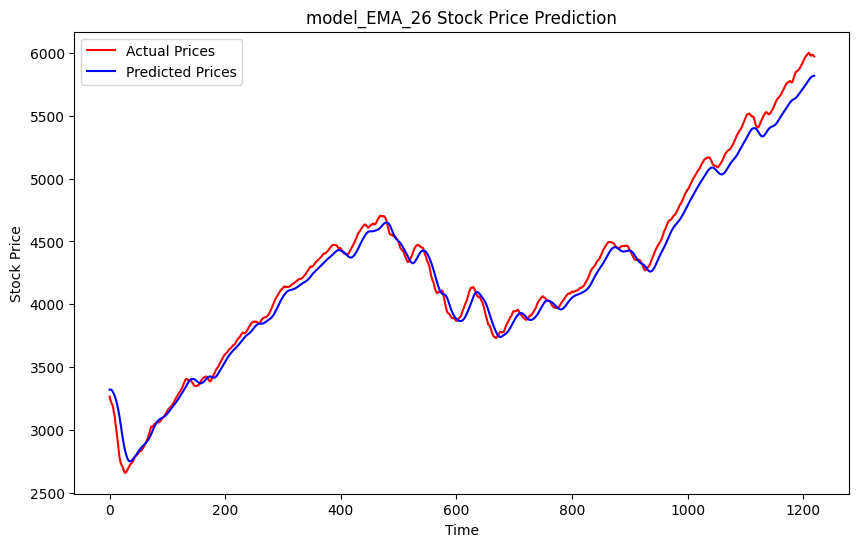

In [ ]:
# Assuming 'predictions' and 'y_test' are defined from the previous code
actual_prices = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0]


plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='red', label='Actual Prices')
plt.plot(predictions, color='blue', label='Predicted Prices')
plt.title('model_EMA_26 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
X_train = pd.DataFrame(df_Time_series['Rolling_Mean'][0: int(len(df_Time_series)*0.80)])
X_test = pd.DataFrame(df_Time_series['Rolling_Mean'][int(len(df_Time_series)*0.80):int(len(df_Time_series))])
print(X_train.shape)
print(X_test.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(X_train)
scaled_data
scaled_data_test = scaler.fit_transform(X_test)
scaled_data_test

(4992, 1)
(1248, 1)


array([[0.20833508],
       [0.21030697],
       [0.21195049],
       ...,
       [0.99904239],
       [0.99725619],
       [0.99489927]])

In [ ]:
x_train = []
y_train = []
roll_back = 28
for i in range(roll_back, scaled_data.shape[0]):
    x_train.append(scaled_data[i-roll_back: i])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((4964, 28, 1), (4964,))

In [ ]:
x_test = []
y_test = []
for i in range(roll_back, scaled_data_test.shape[0]):
    x_test.append(scaled_data_test[i-roll_back: i])
    y_test.append(scaled_data_test[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((1220, 28, 1), (1220,))

In [ ]:
# Build the LSTM model
model_Rolling_Mean = tf.keras.models.Sequential()
model_Rolling_Mean.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_Rolling_Mean.add(tf.keras.layers.Dropout(0.2))
model_Rolling_Mean.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True))
model_Rolling_Mean.add(tf.keras.layers.Dropout(0.2))
model_Rolling_Mean.add(tf.keras.layers.LSTM(units=roll_back))
model_Rolling_Mean.add(tf.keras.layers.Dropout(0.2))
model_Rolling_Mean.add(tf.keras.layers.Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model_Rolling_Mean.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model_Rolling_Mean.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                       │ (None, 28, 28)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_28 (LSTM)                       │ (None, 28, 28)              │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_29 (LSTM)                       │ (None, 28)                  │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              29 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,157 (63.11 KB)

 Trainable params: 16,157 (63.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model_Rolling_Mean.fit(x_train, y_train,validation_data = [x_test,y_test], epochs=25, batch_size=32,verbose=1) # Adjust epochs and batch_size as needed

Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - loss: 0.0325 - val_loss: 0.0019
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0025 - val_loss: 8.3007e-04
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0026 - val_loss: 9.4386e-04
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0017 - val_loss: 9.3634e-04
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0015 - val_loss: 7.2079e-04
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0015 - val_loss: 7.2788e-04
Epoch 9/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0015 - val_loss: 6.4937e-04
Epoch 10/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0014 - val_loss: 6.0270e-04
Epoch 11/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0011 - val_loss: 5.8247e-04
Ep

In [ ]:
# Make predictions
predictions = model_Rolling_Mean.predict(x_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), x_test.shape[2] -1))), axis=1))[:, 0]

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


In [ ]:
# Evaluate the model
rmse = np.sqrt(np.mean(np.square(predictions - scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_test.shape[2] -1))), axis=1))[:, 0])))
print(f"RMSE: {rmse}")

RMSE: 115.5136719578229


In [ ]:
r2 = r2_score(scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0], predictions)
print(f"R-squared: {r2}")

R-squared: 0.975945798359907


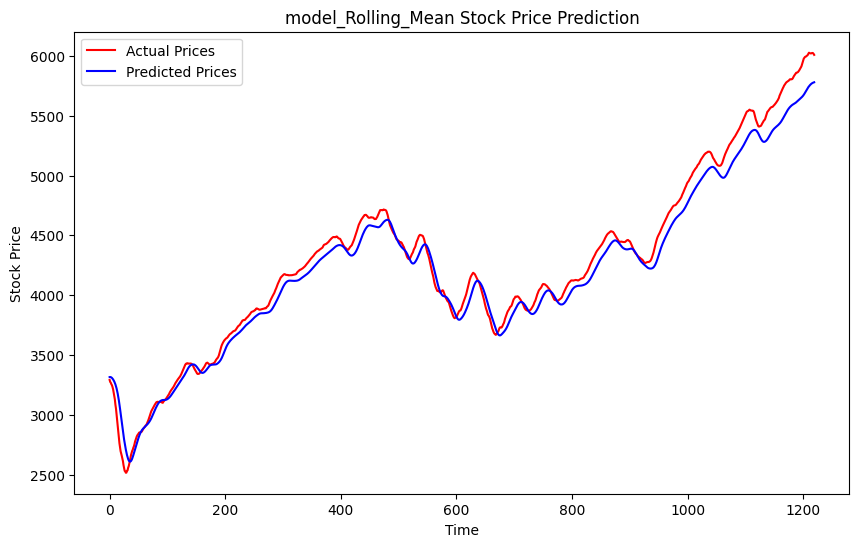

In [ ]:
# Assuming 'predictions' and 'y_test' are defined from the previous code
actual_prices = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0]


plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='red', label='Actual Prices')
plt.plot(predictions, color='blue', label='Predicted Prices')
plt.title('model_Rolling_Mean Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
X_train = pd.DataFrame(df_Time_series['Upper_BB'][0: int(len(df_Time_series)*0.80)])
X_test = pd.DataFrame(df_Time_series['Upper_BB'][int(len(df_Time_series)*0.80):int(len(df_Time_series))])
print(X_train.shape)
print(X_test.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(X_train)
scaled_data
scaled_data_test = scaler.fit_transform(X_test)
scaled_data_test

(4992, 1)
(1248, 1)


array([[0.15620681],
       [0.15954397],
       [0.16189053],
       ...,
       [0.99801673],
       [0.99904972],
       [1.        ]])

In [ ]:
x_train = []
y_train = []
roll_back = 28
for i in range(roll_back, scaled_data.shape[0]):
    x_train.append(scaled_data[i-roll_back: i])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((4964, 28, 1), (4964,))

In [ ]:
x_test = []
y_test = []
for i in range(roll_back, scaled_data_test.shape[0]):
    x_test.append(scaled_data_test[i-roll_back: i])
    y_test.append(scaled_data_test[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((1220, 28, 1), (1220,))

In [ ]:
# Build the LSTM model
model_Upper_BB = tf.keras.models.Sequential()
model_Upper_BB.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_Upper_BB.add(tf.keras.layers.Dropout(0.2))
model_Upper_BB.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True))
model_Upper_BB.add(tf.keras.layers.Dropout(0.2))
model_Upper_BB.add(tf.keras.layers.LSTM(units=roll_back))
model_Upper_BB.add(tf.keras.layers.Dropout(0.2))
model_Upper_BB.add(tf.keras.layers.Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model_Upper_BB.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model_Upper_BB.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                       │ (None, 28, 28)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ (None, 28, 28)              │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_32 (LSTM)                       │ (None, 28)                  │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              29 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,157 (63.11 KB)

 Trainable params: 16,157 (63.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model_Upper_BB.fit(x_train, y_train,validation_data = [x_test,y_test], epochs=25, batch_size=32,verbose=1) # Adjust epochs and batch_size as needed

Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 0.0343 - val_loss: 9.5310e-04
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0021 - val_loss: 9.9913e-04
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 10/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 11/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 12/25
156/156 ━━━━━━

In [ ]:
# Make predictions
predictions = model_Upper_BB.predict(x_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), x_test.shape[2] -1))), axis=1))[:, 0]

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [ ]:
# Evaluate the model
rmse = np.sqrt(np.mean(np.square(predictions - scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_test.shape[2] -1))), axis=1))[:, 0])))
print(f"RMSE: {rmse}")

RMSE: 86.36240486700048


In [ ]:
r2 = r2_score(scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0], predictions)
print(f"R-squared: {r2}")

R-squared: 0.9861277230568498


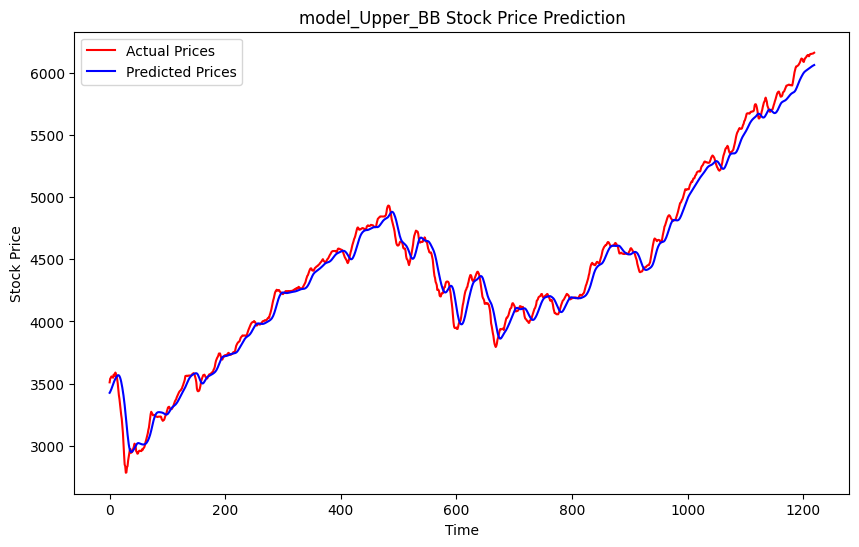

In [ ]:
# Assuming 'predictions' and 'y_test' are defined from the previous code
actual_prices = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0]


plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='red', label='Actual Prices')
plt.plot(predictions, color='blue', label='Predicted Prices')
plt.title('model_Upper_BB Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
X_train = pd.DataFrame(df_Time_series['Lower_BB'][0: int(len(df_Time_series)*0.80)])
X_test = pd.DataFrame(df_Time_series['Lower_BB'][int(len(df_Time_series)*0.80):int(len(df_Time_series))])
print(X_train.shape)
print(X_test.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(X_train)
scaled_data
scaled_data_test = scaler.fit_transform(X_test)
scaled_data_test

(4992, 1)
(1248, 1)


array([[0.28389197],
       [0.28456347],
       [0.28550809],
       ...,
       [0.99251262],
       [0.98831423],
       [0.98313974]])

In [ ]:
x_train = []
y_train = []
roll_back = 28
for i in range(roll_back, scaled_data.shape[0]):
    x_train.append(scaled_data[i-roll_back: i])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((4964, 28, 1), (4964,))

In [ ]:
x_test = []
y_test = []
for i in range(roll_back, scaled_data_test.shape[0]):
    x_test.append(scaled_data_test[i-roll_back: i])
    y_test.append(scaled_data_test[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((1220, 28, 1), (1220,))

In [ ]:
# Build the LSTM model
model_Lower_BB = tf.keras.models.Sequential()
model_Lower_BB.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_Lower_BB.add(tf.keras.layers.Dropout(0.2))
model_Lower_BB.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True))
model_Lower_BB.add(tf.keras.layers.Dropout(0.2))
model_Lower_BB.add(tf.keras.layers.LSTM(units=roll_back))
model_Lower_BB.add(tf.keras.layers.Dropout(0.2))
model_Lower_BB.add(tf.keras.layers.Dense(units=1))  # Output layer for predicting the 'Low' price

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model_Lower_BB.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model_Lower_BB.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                       │ (None, 28, 28)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_34 (LSTM)                       │ (None, 28, 28)              │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_35 (LSTM)                       │ (None, 28)                  │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              29 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,157 (63.11 KB)

 Trainable params: 16,157 (63.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model_Lower_BB.fit(x_train, y_train,validation_data = [x_test,y_test], epochs=25, batch_size=32,verbose=1) # Adjust epochs and batch_size as needed

Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - loss: 0.0303 - val_loss: 0.0013
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0027 - val_loss: 0.0041
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 9/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 10/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 11/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 12/25
156/156 ━━━━━━━━━━━━━━━━

In [ ]:
# Make predictions
predictions = model_Lower_BB.predict(x_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), x_test.shape[2] -1))), axis=1))[:, 0]

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [ ]:
# Evaluate the model
rmse = np.sqrt(np.mean(np.square(predictions - scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_test.shape[2] -1))), axis=1))[:, 0])))
print(f"RMSE: {rmse}")

RMSE: 95.45993293519017


In [ ]:
r2 = r2_score(scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0], predictions)
print(f"R-squared: {r2}")

R-squared: 0.9843988656851516


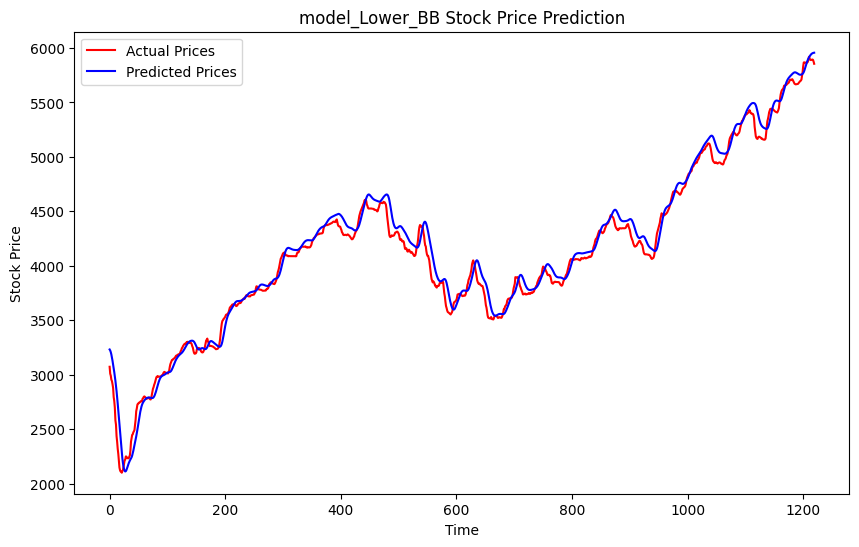

In [ ]:
# Assuming 'predictions' and 'y_test' are defined from the previous code
actual_prices = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0]


plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='red', label='Actual Prices')
plt.plot(predictions, color='blue', label='Predicted Prices')
plt.title('model_Lower_BB Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
X_train = pd.DataFrame(df_Time_series['OBV'][0: int(len(df_Time_series)*0.80)])
X_test = pd.DataFrame(df_Time_series['OBV'][int(len(df_Time_series)*0.80):int(len(df_Time_series))])
print(X_train.shape)
print(X_test.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(X_train)
scaled_data
scaled_data_test = scaler.fit_transform(X_test)
scaled_data_test

(4992, 1)
(1248, 1)


array([[0.15046396],
       [0.16157893],
       [0.14933457],
       ...,
       [0.95623407],
       [0.945993  ],
       [0.93666142]])

In [ ]:
x_train = []
y_train = []
roll_back = 28
for i in range(roll_back, scaled_data.shape[0]):
    x_train.append(scaled_data[i-roll_back: i])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((4964, 28, 1), (4964,))

In [ ]:
x_test = []
y_test = []
for i in range(roll_back, scaled_data_test.shape[0]):
    x_test.append(scaled_data_test[i-roll_back: i])
    y_test.append(scaled_data_test[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((1220, 28, 1), (1220,))

In [ ]:
# Build the LSTM model
model_OBV = tf.keras.models.Sequential()
model_OBV.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_OBV.add(tf.keras.layers.Dropout(0.2))
model_OBV.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True))
model_OBV.add(tf.keras.layers.Dropout(0.2))
model_OBV.add(tf.keras.layers.LSTM(units=roll_back))
model_OBV.add(tf.keras.layers.Dropout(0.2))
model_OBV.add(tf.keras.layers.Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model_OBV.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model_OBV.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                       │ (None, 28, 28)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_37 (LSTM)                       │ (None, 28, 28)              │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_38 (LSTM)                       │ (None, 28)                  │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              29 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,157 (63.11 KB)

 Trainable params: 16,157 (63.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model_OBV.fit(x_train, y_train,validation_data = [x_test,y_test], epochs=25, batch_size=32,verbose=1) # Adjust epochs and batch_size as needed

Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0450 - val_loss: 0.0021
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 9/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 10/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 11/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 12/25
156/156 ━━━━━━━━━━━━━━━━━

In [ ]:
# Make predictions
predictions = model_OBV.predict(x_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), x_test.shape[2] -1))), axis=1))[:, 0]

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [ ]:
# Evaluate the model
rmse = np.sqrt(np.mean(np.square(predictions - scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_test.shape[2] -1))), axis=1))[:, 0])))
print(f"RMSE: {rmse}")

RMSE: 11839508168.88037


In [ ]:
r2 = r2_score(scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0], predictions)
print(f"R-squared: {r2}")

R-squared: 0.9677931184909301


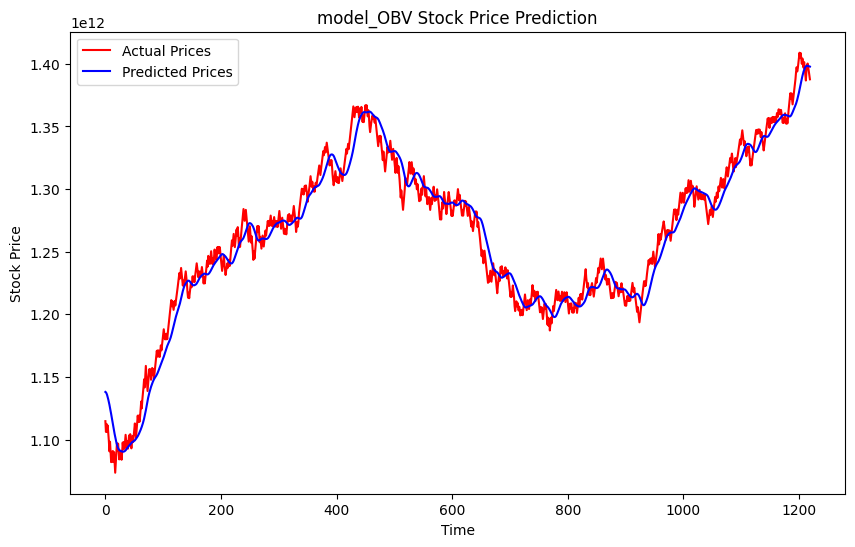

In [ ]:
# Assuming 'predictions' and 'y_test' are defined from the previous code
actual_prices = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0]


plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='red', label='Actual Prices')
plt.plot(predictions, color='blue', label='Predicted Prices')
plt.title('model_OBV Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
X_train = pd.DataFrame(df_Time_series['VPT'][0: int(len(df_Time_series)*0.80)])
X_test = pd.DataFrame(df_Time_series['VPT'][int(len(df_Time_series)*0.80):int(len(df_Time_series))])
print(X_train.shape)
print(X_test.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(X_train)
scaled_data
scaled_data_test = scaler.fit_transform(X_test)
scaled_data_test

(4992, 1)
(1248, 1)


array([[0.61338654],
       [0.61647852],
       [0.61413966],
       ...,
       [0.98149458],
       [0.97360039],
       [0.97072045]])

In [ ]:
x_train = []
y_train = []
roll_back = 28
for i in range(roll_back, scaled_data.shape[0]):
    x_train.append(scaled_data[i-roll_back: i])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((4964, 28, 1), (4964,))

In [ ]:
x_test = []
y_test = []
for i in range(roll_back, scaled_data_test.shape[0]):
    x_test.append(scaled_data_test[i-roll_back: i])
    y_test.append(scaled_data_test[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((1220, 28, 1), (1220,))

In [ ]:
# Build the LSTM model
model_VPT = tf.keras.models.Sequential()
model_VPT.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_VPT.add(tf.keras.layers.Dropout(0.2))
model_VPT.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True))
model_VPT.add(tf.keras.layers.Dropout(0.2))
model_VPT.add(tf.keras.layers.LSTM(units=roll_back))
model_VPT.add(tf.keras.layers.Dropout(0.2))
model_VPT.add(tf.keras.layers.Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model_VPT.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model_VPT.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_39 (LSTM)                       │ (None, 28, 28)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_40 (LSTM)                       │ (None, 28, 28)              │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_41 (LSTM)                       │ (None, 28)                  │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              29 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,157 (63.11 KB)

 Trainable params: 16,157 (63.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model_VPT.fit(x_train, y_train,validation_data = [x_test,y_test], epochs=25, batch_size=32,verbose=1) # Adjust epochs and batch_size as needed

Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 0.0715 - val_loss: 0.0029
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0071 - val_loss: 0.0027
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0058 - val_loss: 0.0022
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0054 - val_loss: 0.0021
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 9/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 10/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 11/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 12/25
156/156 ━━━━━━━━━━━━━━━━━

In [ ]:
# Make predictions
predictions = model_VPT.predict(x_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), x_test.shape[2] -1))), axis=1))[:, 0]

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [ ]:
# Evaluate the model
rmse = np.sqrt(np.mean(np.square(predictions - scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_test.shape[2] -1))), axis=1))[:, 0])))
print(f"RMSE: {rmse}")

RMSE: 160022363.54662108


In [ ]:
r2 = r2_score(scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0], predictions)
print(f"R-squared: {r2}")

R-squared: 0.9435516125349253


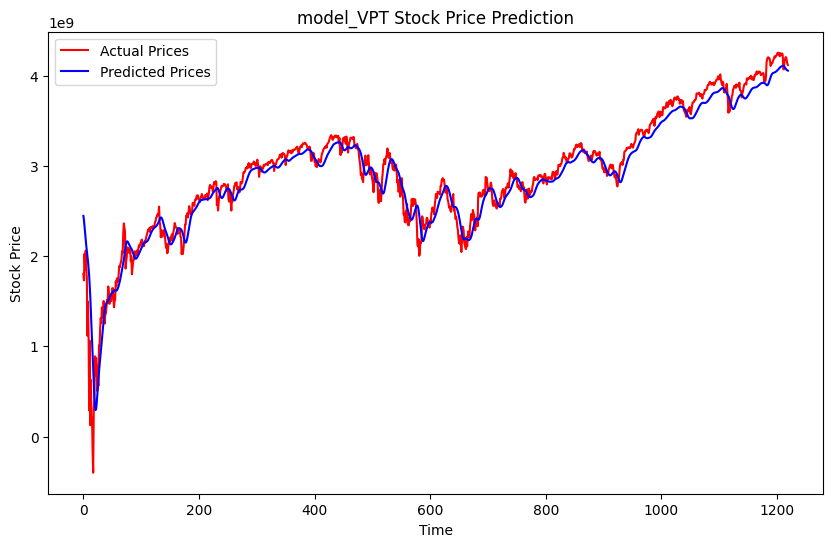

In [ ]:
# Assuming 'predictions' and 'y_test' are defined from the previous code
actual_prices = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0]


plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='red', label='Actual Prices')
plt.plot(predictions, color='blue', label='Predicted Prices')
plt.title('model_VPT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
X_train = pd.DataFrame(df_Time_series['Prev_Close'][0: int(len(df_Time_series)*0.80)])
X_test = pd.DataFrame(df_Time_series['Prev_Close'][int(len(df_Time_series)*0.80):int(len(df_Time_series))])
print(X_train.shape)
print(X_test.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(X_train)
scaled_data
scaled_data_test = scaler.fit_transform(X_test)
scaled_data_test

(4992, 1)
(1248, 1)


array([[0.27301469],
       [0.28015742],
       [0.28348223],
       ...,
       [0.98632703],
       [0.96900228],
       [0.95241727]])

In [ ]:
x_train = []
y_train = []
roll_back = 28
for i in range(roll_back, scaled_data.shape[0]):
    x_train.append(scaled_data[i-roll_back: i])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((4964, 28, 1), (4964,))

In [ ]:
x_test = []
y_test = []
for i in range(roll_back, scaled_data_test.shape[0]):
    x_test.append(scaled_data_test[i-roll_back: i])
    y_test.append(scaled_data_test[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((1220, 28, 1), (1220,))

In [ ]:
# Build the LSTM model
model_Prev_Close = tf.keras.models.Sequential()
model_Prev_Close.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_Prev_Close.add(tf.keras.layers.Dropout(0.2))
model_Prev_Close.add(tf.keras.layers.LSTM(units=roll_back, return_sequences=True))
model_Prev_Close.add(tf.keras.layers.Dropout(0.2))
model_Prev_Close.add(tf.keras.layers.LSTM(units=roll_back))
model_Prev_Close.add(tf.keras.layers.Dropout(0.2))
model_Prev_Close.add(tf.keras.layers.Dense(units=1))  # Output layer for predicting the 'Low' price

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model_Prev_Close.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model_Prev_Close.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_42 (LSTM)                       │ (None, 28, 28)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_43 (LSTM)                       │ (None, 28, 28)              │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_44 (LSTM)                       │ (None, 28)                  │           6,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              29 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,157 (63.11 KB)

 Trainable params: 16,157 (63.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model_Prev_Close.fit(x_train, y_train,validation_data = [x_test,y_test], epochs=25, batch_size=32,verbose=1) # Adjust epochs and batch_size as needed

Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0364 - val_loss: 0.0014
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 9/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 10/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 11/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 12/25
156/156 ━━━━━━━━━━━━━━━━━

In [ ]:
# Make predictions
predictions = model_Prev_Close.predict(x_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), x_test.shape[2] -1))), axis=1))[:, 0]

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [ ]:
# Evaluate the model
rmse = np.sqrt(np.mean(np.square(predictions - scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_test.shape[2] -1))), axis=1))[:, 0])))
print(f"RMSE: {rmse}")

RMSE: 105.49532449559136


In [ ]:
r2 = r2_score(scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0], predictions)
print(f"R-squared: {r2}")

R-squared: 0.980672596506021


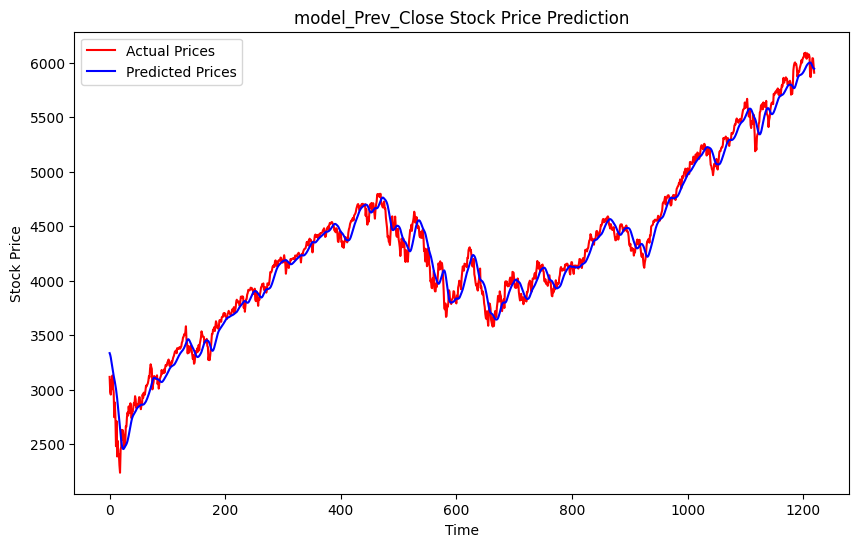

In [ ]:
# Assuming 'predictions' and 'y_test' are defined from the previous code
actual_prices = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), x_train.shape[2] -1))), axis=1))[:, 0]


plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='red', label='Actual Prices')
plt.plot(predictions, color='blue', label='Predicted Prices')
plt.title('model_Prev_Close Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()